# Predict Future Sales
The final project of “How to Win a Data Science Competition” Course in the Advanced ML Specialisation from HSE

### Project description
<b>Task: </b> Monthly sale prediction for one of the largest Russian software chaplains.<br>
 
https://www.kaggle.com/c/competitive-data-science-predict-future-sales/overview

Result: ~78th place out of about 12000 teams:

<img src="screenshot_score.png" width=700 align="left"/><br clear="all" />

best rmse score: 0.75, naïve benchmark: 1.16.

Data sources:  
- daily transactions for 3 years; 
- items / item categories textual description 
- shops textual description.

Problem specification:
- large amount of data: about 60 shops and 21000 items, more than 10e6 rows in the training set,
- row data format: necessity of tricky feature engineering,
- inhomogeneous distribution of items by shops and time,
- different nature of objects in the data set: new releases, positions with and without sale history,
- high sensibility to specific monthly sets of new releases.

Main aspects of the solution:
- advanced feature engineering  (see below), 
- grouping of items, according to similarity of their textual description in a vectorised space (see below), 
- splitting all objects (item/month/shop) into three groups according to their nature and further separately modelling of each group (see part 2).

<img src="screenshot model.png" width=900 align="left"/><br clear="all" />

Some axillary functions were packed into "aml_2_lib" module.

<nav class="toc">
<h2>Content:</h2>
<h4> Part 1: EDA, feature selection and data aggregation</h4>
<ol>
<li><a href="#data">Data</a>
<li><a href=“#eda”>EDA</a>
<li><a href="#fe"> Feature engineering</a>
      <ol>
        <li><a href="#fe_name"> Information in item textual description</a>
        <li><a href="#time"> Time based features</a>
        <li><a href="#fe_name"> Information in item textual description</a>            
        <li><a href="#clustering"> Shops clustering</a>
        <li><a href="#aggregation"> Data aggregation</a>
        <li><a href="#other"> Other features and statistics</a>    
      </ol>
</ol>
<h4> Part 2: Modeling</h4>
<ol>
(the 2d notebook)
</ol>
</nav>

In [15]:
import pandas as pd
import numpy as np
from os import path
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import pickle
import gc
gc.enable()

%matplotlib inline 

In [8]:
import datetime
from workalendar.europe import Russia
from calendar import monthrange
from itertools import product
from sklearn import preprocessing

from aml_2_lib import get_grid, Sales_pt, reduce_mem_usage, to_vec

In [9]:
import re
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from nltk.util import bigrams, ngrams
import nltk

In [10]:
plt.style.use(['seaborn'])

<h1 id="data"> Data</h1>

In [4]:
DATA_FOLDER = path.join('final project', 'data')

In [5]:
transactions    = reduce_mem_usage(pd.read_csv(path.join(DATA_FOLDER, 'sales_train.csv')))
items           = pd.read_csv(path.join(DATA_FOLDER, 'items.csv'))
item_categories = pd.read_csv(path.join(DATA_FOLDER, 'item_categories.csv'))
shops           = pd.read_csv(path.join(DATA_FOLDER, 'shops.csv'))
kaggle_test = pd.read_csv(path.join(DATA_FOLDER, 'test.csv'))

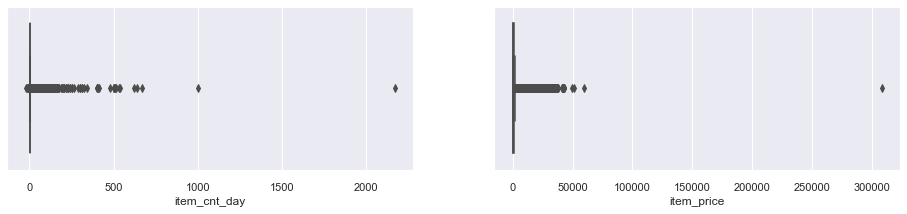

In [6]:
#outliers
seaborn.set()
fig, axs = plt.subplots(1, 2, figsize=(16, 3))

seaborn.boxplot(x=transactions.loc[:, 'item_cnt_day'], ax= axs[0])
seaborn.boxplot(x=transactions.loc[:, 'item_price'], ax= axs[1])

In [ ]:
transactions.loc[:, 'date'] = transactions.loc[:, 'date'].map(lambda d: datetime.datetime.strptime(d, '%d.%m.%Y'))
d0 =  np.sort(transactions.date.unique()).min()

In [8]:
# data mistakes correction (see below)
transactions.loc[:, 'shop_id'].replace(to_replace={0:57, 1:58, 11:10, 40:39}, inplace=True)

In [9]:
transactions = transactions[(transactions['item_cnt_day']<1000)]
transactions = transactions[(transactions['item_price']>0)&(transactions['item_price']<50000)]

<h1 id="eda"> EDA</h1>

An attempt, source by source, to get a feeling of the data. Currently there were found a few mistakes in the data and there were conducted some aggregations for the purposes of the further feature engineering. 

### Sales

#### Train set

In [10]:
transactions.loc[:, 'revenue'] = transactions.apply(lambda x: x['item_cnt_day']*x['item_price'], axis=1)

In [30]:
print(transactions.shape)
transactions.head()

(2935843, 8)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,revenue,total_days
0,2013-01-02,0,59,22154,999.000000,1,999.000000,1.0
1,2013-01-03,0,25,2552,899.000000,1,899.000000,2.0
2,2013-01-05,0,25,2552,899.000000,-1,-899.000000,4.0
3,2013-01-06,0,25,2554,1709.050049,1,1709.050049,5.0
4,2013-01-15,0,25,2555,1099.000000,1,1099.000000,14.0


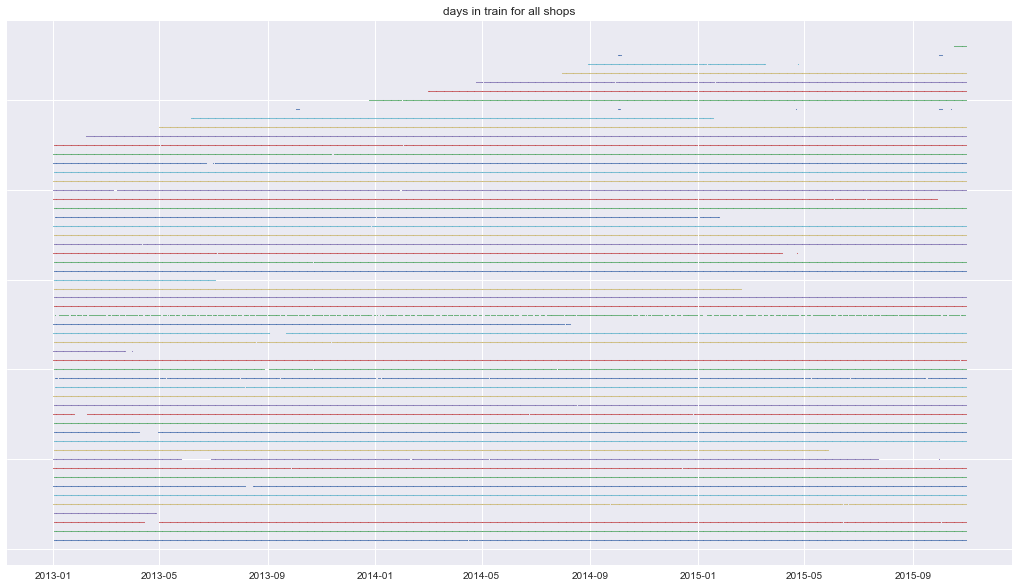

In [11]:
#shops, that were opend/closed during

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(18, 10))
axes.set_title('days in train for all shops')
axes.set(yticklabels=[])

days_in = pd.DataFrame([], columns=['shop_id', '#days'])
for i, s in enumerate(transactions.shop_id.unique()):
    dates = np.sort(transactions[transactions.shop_id==s].date.unique())
    days = (i+1)*np.ones(dates.shape[0])
    axes.scatter(dates, days, s=0.5, label='days')
    days_in.loc[i, :] = [s, len(days)]

##### Intro-month statistics and monthly agregation
The final goal of the project is monthly forecasting, so the data should be monthly aggregated, <br> but some values can be interesting in their intra-month representation:

- Length of the sale history of a particular item in days ("days on the market")  
- Length of the sale history for each shop ("days in the shop")
- How many days ago a shop started to operate
- Some other statistics

In [12]:
f = lambda x: (x - d0)/ np.timedelta64(1, 's')//(3600*24)
transactions.loc[:, 'total_days'] = transactions.loc[:, 'date'].map(f)

In [13]:
# first sales
first_day = {}
first_day['item'] = transactions.groupby('item_id', as_index=False).total_days.min().astype(int)
first_day['item/shop'] = transactions.groupby(['shop_id', 'item_id'], as_index=False).total_days.min().astype(int)
first_day['shop'] = transactions.groupby('shop_id', as_index=False).total_days.min().astype(int)

In [23]:
# intro-month statistics
tmp = transactions.loc[:, ['date', 'date_block_num', 'shop_id', 'item_id', 'item_cnt_day']]
tmp['d'] = tmp['date'].map(lambda x: x.day)
tmp = tmp.pivot_table(index=['date_block_num', 'shop_id', 'item_id'], columns='d', 
                                            values='item_cnt_day', aggfunc='sum') 

months_statistics = tmp.reset_index().iloc[:, :3]
months_statistics.loc[:, 'month_n_sales'] = tmp.apply(lambda x: x.count(), axis=1).values
months_statistics.loc[:, 'month_mean'] = tmp.apply(lambda x: x.mean(), axis=1).values
months_statistics.loc[:, 'month_median'] = tmp.apply(lambda x: x.median(), axis=1).values

def g(x):
    try: return list(reversed(x)).index(1)
    except ValueError: return np.nan
tmp = transactions.loc[:, ['date', 'date_block_num', 'shop_id', 'item_id', 'item_cnt_day']]
tmp['d'] = tmp['date'].map(lambda x: x.day)
months_statistics['month_last_sale_lag'] = tmp.pivot_table(index=['date_block_num', 'shop_id', 'item_id'], columns='d', 
                                              aggfunc='count').fillna(0).apply(lambda x: g(x), axis=1).values

[Text(0.5, 0, 'days')]

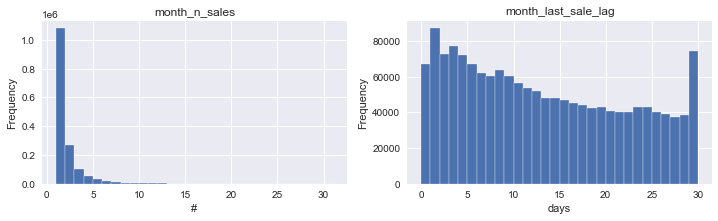

In [1240]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))
months_statistics['month_n_sales'].plot(kind='hist',  bins=30, ax=axes[0], title='month_n_sales')
months_statistics['month_last_sale_lag'].plot(kind='hist', bins=30, ax=axes[1], title='month_last_sale_lag')
axes[0].set(xlabel='#')
axes[1].set(xlabel='days')

In [24]:
months_statistics.to_csv('months_statistics.csv')

In [14]:
# monthly agregation

head_index = ['date_block_num', 'shop_id', 'item_id']
columns = ['date_block_num', 'shop_id', 'item_id', 'item_cnt_day', 'revenue']
main_data = transactions.loc[:, columns].groupby(head_index, as_index=False).sum()
main_data.rename(columns={'item_cnt_day': 'item_cnt_month'}, inplace=True)
main_data.rename(columns = {'item_cnt_month': 'sales'}, inplace=True)

# averege items price
columns = ['date_block_num', 'shop_id', 'item_id', 'item_price']
main_data.loc[:, 'price'] = transactions.loc[:, columns].groupby(['date_block_num', 'shop_id', 'item_id'], 
                                                                  as_index=False).mean().loc[:, 'item_price']

[Text(0.5, 0, '# items')]

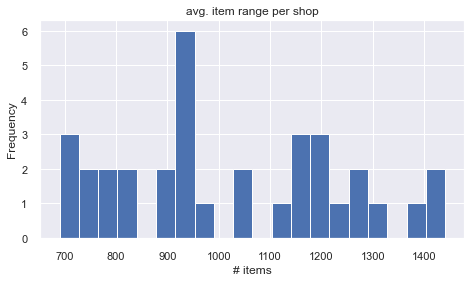

In [56]:
# item range per shop
ax=(main_data.groupby(['shop_id', 'date_block_num']).item_id.agg(lambda x: x.value_counts().shape[0])).groupby(
    'date_block_num').mean().plot(kind='hist',  bins=20, figsize=(7.6, 4), title='avg. item range per shop')
ax.set(xlabel='# items')

[Text(0.5, 0, 'sales')]

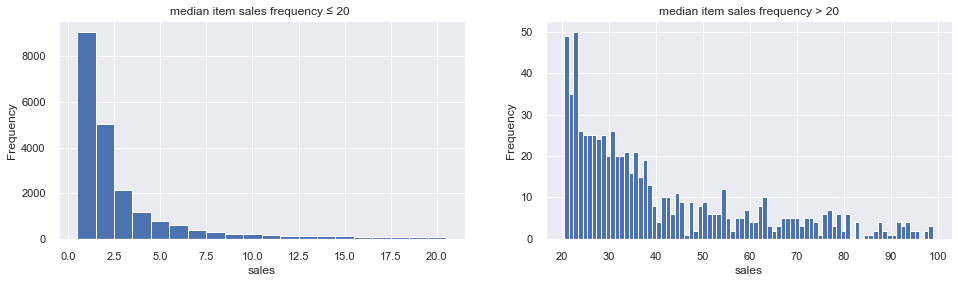

In [57]:
tmp=(main_data.groupby(['item_id', 'shop_id'], as_index=False).sales.sum()).groupby('item_id').sales.median()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
tmp[((tmp>0))&(tmp<21)].plot(kind='hist',  bins=20, title='median item sales frequency ≤ 20 ', ax=axes[0])
tmp[(tmp>20)&(tmp<100)].plot(kind='hist',  bins=80, title='median item sales frequency > 20', ax=axes[1])
axes[0].set(xlabel='sales')
axes[1].set(xlabel='sales')

In [58]:
print('median item sales frequency>100: {}'.format(tmp[tmp>100].shape[0]))

median item sales frequency>100: 145


[Text(0.5, 0, 'months')]

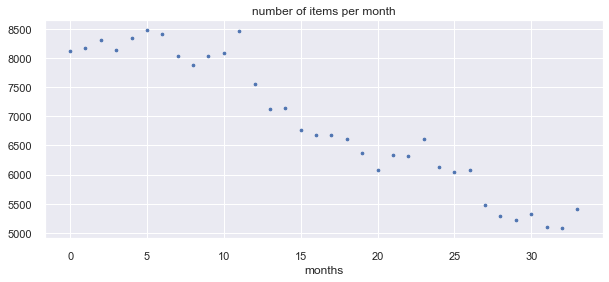

In [59]:
tmp=main_data.groupby('date_block_num').item_id.agg(lambda x: x.value_counts().shape[0])
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
axes.set_title('number of items per month')
axes.scatter(tmp.index, tmp, s=7)
axes.set(xlabel='months')

[Text(0.5, 0, 'months')]

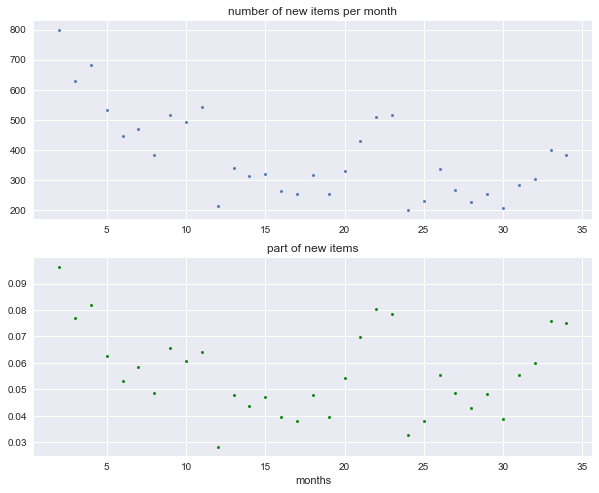

In [969]:
to_plot = [[], [], []]
for m in range(2, main_data.date_block_num.max()+1):
    s = set(main_data[main_data.date_block_num==m].item_id.unique())
    n = len(s - set(main_data[main_data.date_block_num<m].item_id.unique()))
    to_plot[0].append(m)
    to_plot[1].append(n)
    to_plot[2].append(n/len(s))

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))
axes[0].set_title('number of new items per month')
axes[0].scatter(to_plot[0], to_plot[1], s=7)

axes[1].set_title('part of new items')
axes[1].scatter(to_plot[0], to_plot[2], s=7, c='green')
axes[1].set(xlabel='months')

#### Test set

In [60]:
kaggle_test = pd.read_csv(path.join(DATA_FOLDER, 'test.csv'))
kaggle_test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [61]:
train_items = main_data.item_id.unique()
test_items = kaggle_test.item_id.unique()
n = len(set(test_items) - set(train_items))
print('# of items in train: {}'.format(len(train_items)))
print('# of items in test: {}'.format(len(test_items)))
print('# of new items in test: {}, {:.2f} from test'.format(n, n/len(test_items)))

# of items in train: 21805
# of items in test: 5100
# of new items in test: 363, 0.07 from test


In [62]:
n = (kaggle_test.groupby('shop_id').item_id.count()).mean()
print('structure of test set: {:.2f} items per shop'.format(n))
print('the same structure for each shop: {}'.format(n*(kaggle_test.shop_id.unique()).shape[0] == kaggle_test.shape[0]))

structure of test set: 5100.00 items per shop
the same structure for each shop: True


In [15]:
kaggle_test.loc[:, 'date_block_num'] = [34]*kaggle_test.shape[0]
main_data = pd.concat([main_data, kaggle_test.loc[:, ['date_block_num', 'shop_id', 'item_id']]], axis=0)

In [16]:
# add item_category_id
main_data = main_data.merge(items.loc[:, ['item_id', 'item_category_id']], how = 'left', on=['item_id'])

columns = ['date_block_num', 'shop_id', 'item_category_id']
main_data.loc[:, columns] = main_data.loc[:, columns].astype(np.int8)
main_data.loc[:, 'item_id'] = main_data.loc[:, 'item_id'].astype(np.int32)

In [17]:
#check
main_data.date_block_num.max()

34

Best selling items: Tickets, Delivery, some Game titels, digital carts (eg. iTunes)

#### Prices

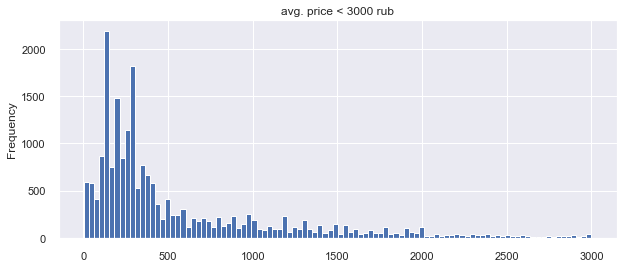

In [66]:
tmp = main_data.groupby('item_id').price.mean()
tmp[tmp<3000].plot(kind='hist', bins=100, figsize=(10, 4), title='avg. price < 3000 rub')

In [67]:
ii = tmp[tmp>=3000].index
print('# of sales of expencive goods: {}'.format(main_data[(main_data['date_block_num']<34)&(main_data['item_id'].isin(ii))].shape[0]))

# of sales of expencive goods: 42906


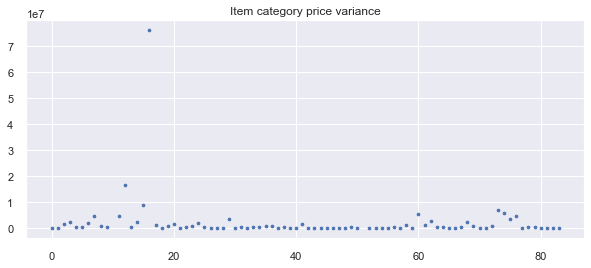

In [68]:
tmp = main_data.groupby('item_category_id').price.agg(np.var)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
ax.set_title('Item category price variance')
ax.scatter(tmp.index, tmp, s=7)

[Text(0.5, 0, 'item_ids')]

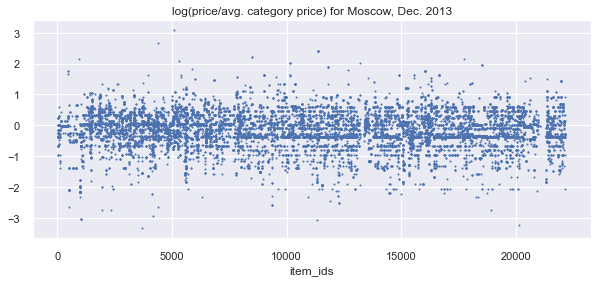

In [79]:
tmp = main_data[(main_data['date_block_num']==11)&(main_data['places']=='Москва')].groupby('item_category_id').price.mean()
tmp = main_data[(main_data['date_block_num']==11)&(main_data['places']=='Москва')].loc[:, 
                    ['item_id', 'price', 'item_category_id']].merge(tmp, how='left',
                                                                    right_index=True, left_on='item_category_id')
tmp['price'] = (tmp['price_x']/tmp['price_y']).map(np.log)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
ax.set_title('log(price/avg. category price) for Moscow, Dec. 2013')
ax.scatter(tmp.item_id, tmp.price, s=1)
ax.set(xlabel='item_ids')

In [ ]:
# features extraction
# One month price lad, diff and relative price for item category/shop

columns = ['date_block_num', 'shop_id', 'item_id', 'price']
prices = main_data.loc[:, columns].pivot_table(index=['shop_id', 'item_id'], columns='date_block_num', 
                                               values='price')
prices = prices.reset_index().reset_index().drop('index', axis=1)
prices.columns.name=''
prices.loc[:, 34] = np.nan
prices.iloc[:, 2:] = prices.iloc[:, 2:].fillna(method='ffill', axis=1)

prices_2 = copy.deepcopy(prices.iloc[:, :])
prices_2.iloc[:, 2:] = prices_2.iloc[:, 2:].shift(2, axis = 1)
prices_2 = prices_2.set_index(['shop_id', 'item_id']).stack().reset_index()
prices_2 = prices_2.rename(columns = {0: 'price_lag_2', '': 'date_block_num'})

prices.iloc[:, 2:] = prices.iloc[:, 2:].shift(1, axis = 1)
prices = prices.set_index(['shop_id', 'item_id']).stack().reset_index()
prices = prices.rename(columns = {0: 'price_lag', '': 'date_block_num'})

prices = prices.merge(prices_2, how='left', on=['shop_id', 'item_id', 'date_block_num'])
prices.loc[:, 'price_diff_lag'] = prices.loc[:, 'price_lag'] - prices.loc[:, 'price_lag_2'] 
prices.drop('price_lag_2', inplace=True, axis=1)

prices = prices.merge(items.loc[:, ['item_id', 'item_category_id']], how='left', on='item_id')
prices['places'] = prices['shop_id'].replace(places)

#relative prices
tmp = prices.groupby(['date_block_num', 'places', 'item_category_id'], as_index=False).price_lag.mean()
tmp = tmp.rename(columns={'price_lag': 'price'})
prices = prices.merge(tmp, how='left', on=['date_block_num', 'places', 'item_category_id'])
prices['price_relative'] = (prices['price_lag']/prices['price']).map(np.log)
prices.drop(['item_category_id', 'places', 'price'], inplace=True, axis=1)

filename = 'sale_prices.csv'
prices.to_csv(filename)

#### Time

In [70]:
# invariant shops
tmp = main_data.groupby('shop_id').date_block_num.agg(lambda x: x.value_counts().shape[0])
invariant_shops = tmp[tmp==35].index

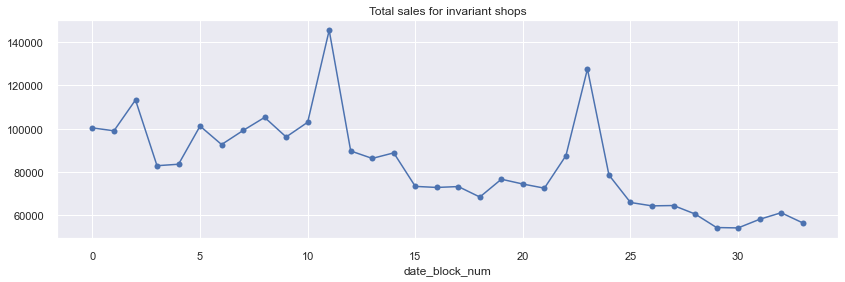

In [71]:
main_data[(main_data['date_block_num']<34)&
          (main_data['shop_id'].isin(invariant_shops))].groupby('date_block_num').sales.sum().plot(style='-o', 
                                   figsize=(14, 4), title='Total sales for invariant shops')

### Shops

In [18]:
shops.loc[:, 'places'] = shops.loc[:, 'shop_name'].map(lambda b: b.split(' ')[0].replace('!', ''))

In [73]:
shops.head()

,shop_name,shop_id,places
0,"!Якутск Орджоникидзе, 56 фран",0,Якутск
1,"!Якутск ТЦ ""Центральный"" фран",1,Якутск
2,"Адыгея ТЦ ""Мега""",2,Адыгея
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха
4,"Волжский ТЦ ""Волга Молл""",4,Волжский


There are few mistakes in the data. 0 --> 57, 1 --> 58, 11 --> 10 corresponds to the same places

In [32]:
print('# of shops: {}'.format(shops.shop_id.unique().shape[0]))
print('# of places: {}'.format(shops.places.unique().shape[0]))

# of shops: 57
# of places: 31


In [74]:
#places with mothe then 1 shop
tmp = shops.groupby('places').shop_id.agg(lambda x: x.value_counts().shape[0]).sort_values(ascending=False)
tmp[tmp>1]

places
Москва          13
Якутск           4
Тюмень           3
Воронеж          3
РостовНаДону     3
Н.Новгород       2
СПб              2
Казань           2
Новосибирск      2
Самара           2
Жуковский        2
Уфа              2
Красноярск       2
Name: shop_id, dtype: int32

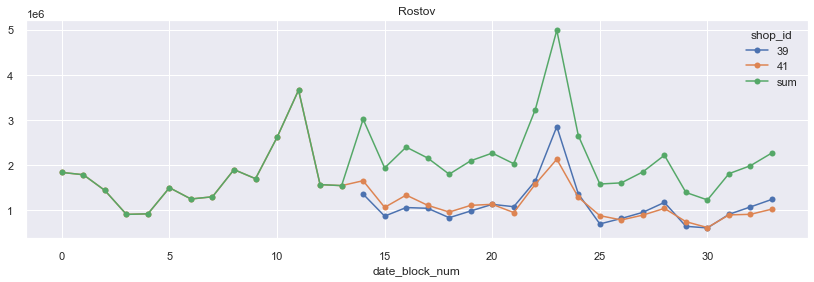

In [75]:
# there are many shops, that were opend/closed during the period
# an example. 2 shops in rostov-on-don. month revenue

tmp = main_data[main_data.date_block_num<34].loc[:, ['date_block_num', 'shop_id', 'revenue']].groupby(['date_block_num', 'shop_id']).sum().unstack()
tmp.columns = tmp.columns.droplevel(0)
rostov = tmp.loc[:, [39, 41]]
rostov.loc[:, 'sum'] = tmp.loc[:, [39, 41]].fillna(0).apply(sum, axis=1)
rostov.plot(style='-o', figsize=(14, 4), title='Rostov')

In [19]:
# mapper
places = shops.loc[:, ['shop_id', 'places']].set_index('shop_id').to_dict()['places']

In [20]:
main_data['places'] = main_data.shop_id.replace(places)

In [81]:
tmp = days_in.sort_values('#days', ascending=True)
tmp['places'] = tmp.shop_id.replace(places)
tmp.head()

,shop_id,#days,places
54,20,9,Москва
55,36,14,Новосибирск
48,9,14,Выездная
21,8,84,Воронеж
3,23,117,Москва


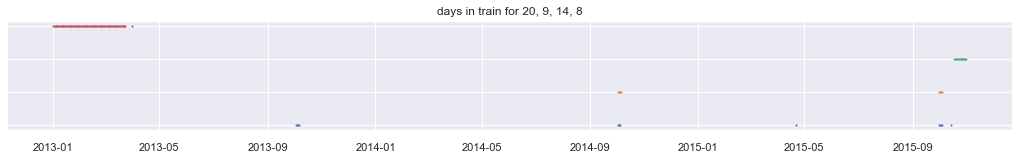

In [282]:
#20, 9, 14, 8
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(18, 2))
axes.set_title('days in train for 20, 9, 14, 8')
axes.set(yticklabels=[])
for i, s in enumerate([9, 20, 36, 8]):
    dates = np.sort(transactions[transactions.shop_id==s].date.unique())
    days = (i+1)*np.ones(dates.shape[0])
    axes.scatter(dates, days, s=1, label='days')
    days_in.loc[i, :] = [s, len(days)]

In [21]:
ii = main_data[main_data.shop_id.isin({9, 20})].index
main_data.drop(ii, inplace=True)

In [ ]:
# n of shops per city / month
main_data['places'] = main_data['shop_id'].replace(places)

n_shops_place = main_data.loc[:, ['date_block_num', 'shop_id', 'places']].groupby(
                       ['date_block_num', 'places']).nunique().loc[:, 'shop_id']
n_shops_place = n_shops_place.reset_index()
n_shops_place.rename(columns={'shop_id': 'n_shops_place'}, inplace=True)

tmp = n_shops_place.copy()
tmp.date_block_num = tmp.date_block_num.map(lambda x: x+1)
tmp = tmp.rename(columns={'n_shops_place': 'n_shops_place_2'})
n_shops_place = n_shops_place.merge(tmp, how='left', on=['date_block_num', 'places'])
n_shops_place['n_shops_place_delta'] = n_shops_place['n_shops_place_2'] - n_shops_place['n_shops_place']
n_shops_place.drop('n_shops_place_2', inplace=True, axis=1)

filename = 'n_shops_place.csv'
n_shops_place.to_csv(filename)

According to the analysies of shop names it is possible to say about 4 kinds of shops

In [22]:
kind_of_shops = {2: [12], 3: [55], 1: [6, 57, 22, 10]}
kind_of_shops = {i: k for k in kind_of_shops.keys() for i in kind_of_shops[k]}
f = lambda x: 0 if x not in kind_of_shops.keys() else x
shops.loc[:, 'kind_of_shops'] = shops.loc[:, 'shop_id'].map(f).replace(kind_of_shops)
kind_of_shops = shops.loc[:, ['shop_id', 'kind_of_shops']]

filename = 'kind_of_shops.csv'
kind_of_shops.to_csv(filename)

In [23]:
shops.to_csv('shops_plus.csv')

###  Items 

#### Item categories

In [24]:
item_categories = pd.read_csv(path.join(DATA_FOLDER, 'item_categories.csv'))

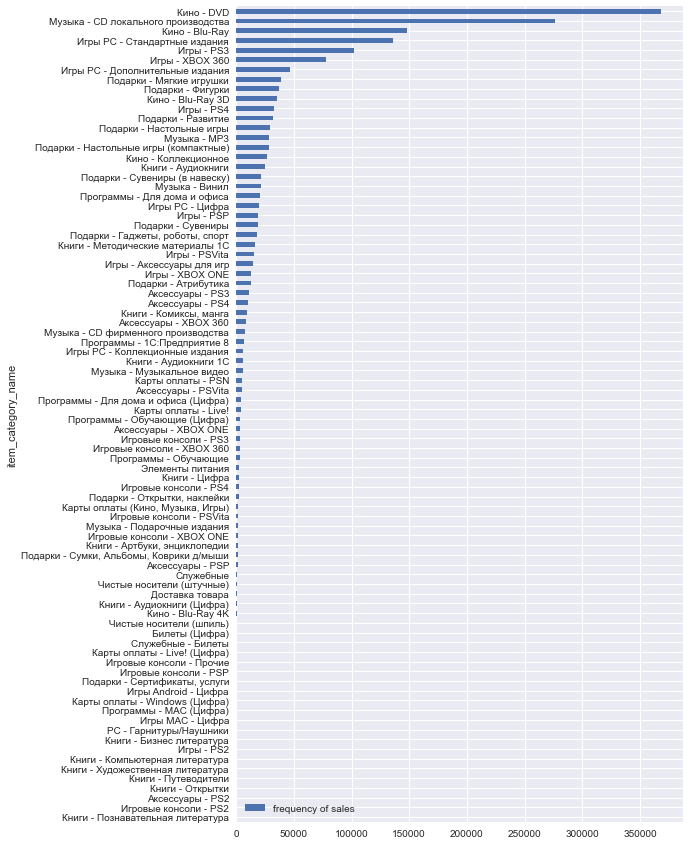

In [25]:
item_categories.loc[:, 'n of items'] = items.loc[:, 
                                     'item_category_id'].value_counts().to_frame().sort_index().values
item_categories.loc[:, 'frequency of sales'] = main_data.loc[:, 'item_category_id'].value_counts().sort_index()

fig, ax = plt.subplots(figsize=(8, 15))
item_categories.sort_values('frequency of sales').plot.barh(x='item_category_name', y='frequency of sales', ax=ax)

In [26]:
most_popular_categories = item_categories.sort_values('frequency of sales').item_category_id.values[:6]

Item categories could be aggregated by some parameters:

- platforms: PSP, PSVita, 1C
- meta categories: games,  game consoles, music etc.
- type of product: gifts, digital producs, merchandising

In [27]:
# several replacements 
def replace_(ss):
    for b in ['Коллекционное', 'Подарочные издания', 'Коллекционные издания']: 
        if b in ss: ss = ss.replace(b, 'Gifts') 
    if 'Игры - Аксессуары для игр' in ss: ss = ss.replace('Игры - Аксессуары для игр', 'Аксессуары')
    elif 'Книги - Аудиокниги 1С' in ss: ss = ss.replace('Книги - Аудиокниги 1С', '1С manuals')
    elif 'Книги - Методические материалы 1С' in ss: ss = ss.replace('Книги - Методические материалы 1С', '1С manuals')
    elif 'Программы - 1С:' in ss: ss = ss.replace('Программы - 1С', '1С: ')
    elif 'Настольные игры' in ss:ss = ss.replace('Настольные игры', 'table games')
    return ss
item_categories.loc[:, 'item_category_name'] = item_categories.loc[:, 'item_category_name'].map(replace_) 

# additional features from item_categories
categories_groups = {'category_groups': ['Аксессуары', 
                                         'Программы - Обучающие', 'Программы',
                                'Игровые консоли', 'Музыка', 'Карты оплаты',
                                'Кино','table games', 'Аудиокниги', 'Игры', '1С manuals', 'Служебные'],
                     'platforms': ['PS2', 'PS3', 'PS4', 'PSP', 'PSVita', 'XBOX 360', 'XBOX ONE', 'PC', 
                                   'Android', 'MAC', '1С'],
                     'types': ['Подарки', 'Gifts', 'Цифра', 'Атрибутика']}

tmp = np.array([])
for b in item_categories.loc[:, 'item_category_name']: 
    tmp = np.concatenate([tmp, to_vec(b, sub_categories = categories_groups)], axis=0)
columns = []
for k in categories_groups.keys(): 
    item_categories.loc[:, k] = [np.nan]*item_categories.shape[0]
    columns.append(k)
item_categories.loc[:, columns] = np.reshape(tmp, (-1, 3))
item_categories.loc[:, columns] = item_categories.loc[:, columns].replace('',  np.nan)

item_categories.loc[32, 'category_groups'] = 'Карты оплаты'

In [28]:
columns = ['item_category_id', 'category_groups', 'platforms', 'types']
main_data = main_data.merge(item_categories.loc[:, columns], how='left', on='item_category_id')

In [29]:
#structure

def agregator(keys, column, new_name, agg='sum'):
    global main_data 
    tmp = main_data.loc[:, keys+[column]].groupby(keys, as_index=False).agg(agg)
    tmp.rename(columns={column: new_name}, inplace=True)
    return tmp

tmp = agregator(['date_block_num', 'shop_id'], 'sales', 'shop_sales', agg='sum')
main_data = main_data.merge(tmp, how = 'left', on=['date_block_num', 'shop_id'])
        
columns =['date_block_num', 'shop_id', 'item_category_id']
tmp = agregator(columns, 'sales', 'category_shop_sales_sum', agg='sum')
main_data = main_data.merge(tmp, how = 'left', on=columns)

main_data.loc[:, 'category_shop_sales_structure'] = main_data.loc[:, 'category_shop_sales_sum'] / main_data.loc[:, 'shop_sales'] 

In [30]:
main_data.to_csv('main_data.csv') 

#### Item names

In [59]:
items = pd.read_csv(path.join(DATA_FOLDER, 'items.csv'))

In [321]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [64]:
music=item_categories[item_categories.category_groups=='Музыка'].item_category_id.values
items[items.item_category_id.isin(music)].item_name.map(text_name)[190:200]

1325                    ARMSTRONG LOUIS  Hello Louis  2CD
1326                 ARMSTRONG LOUIS  Louis And Good Book
1327             ARMSTRONG LOUIS  Louis And Good Book  LP
1328                  ARMSTRONG LOUIS  Plays WC Handy  LP
1329                     ARMSTRONG LOUIS  Summertime  2CD
1330    ARMSTRONG LOUIS  The Okeh  Columbia  RCA Victo...
1331           ARMSTRONG LOUIS  FITZGERALD ELLA  Together
1332      ARMSTRONG LOUIS  FITZGERALD ELLA  Together  2CD
1333      ARMSTRONG LOUIS  FITZGERALD ELLA  Together  2LP
1334    ARMSTRONG LOUIS  FITZGERALD ELLA  ARMSTRONG LO...
Name: item_name, dtype: object

An item name contains several elements: 
- the name, eg. '!ABBYY FineReader 12 Professional Edition Full'
- severall atributes in ( ) and/or [ ] brackets , eg. [PС, Jewel, русская версия], (UNI)
- other atributes over space or slash eg. '/2DVD/ D', D 
- Band name is always in the upper register eg 'ARMSTRONG LOUIS  Summertime'

<h1 id="fe"> Feature engineering</h1>

The most crucial stage of the project. According to the data source it can be splitted into the following substages:

- Item and item category textual descriptions:
	- different attributes in brackets/category name, such as: language, platform, region etc.;
	- items cosine similarity indices  (see below), 
- Time based features: length of the shop/market sale history, number of month from the last sale, age of the shop, calendar features and some others.
- Transaction base features: historical sales, revenue, prices, relative prices, 
- Geography based features: sales of other shops in the same city, weighted horizontal differences in sales. 
- Several statics and other aggregating characteristics: sales frequencies, shop/category priority, average first sale for each category/shop, sale structures etc.
- Shop clustering according to their sale structure.

All time dependent features were lagged, for some of them were applyed some aggregation statistics, such as: exponential moving average, difference, historical mean value, cumulative sum. Also sales histories were aggregated by different categorical features: shops, item categories, clusters, similar items and so on. So, it can be considered as a sort of mean encoding but only on the historical data. 

<h2 id="fe_name"> Information in item textual description</h2>

#### Atributes in brackets 

In [31]:
def text_in_brackets(string):
    b = re.search('(?<=\[).*?(?=\])', string.lower())
    if b!=None: b = b.group()
    else: b = ''
    a = re.search('(?<=\().*?(?=\))', string.lower())
    if a!=None: a = a.group()
    else: a = ''
    return re.sub(r'[^a-zA-Zа-яА-Я0-9\s]', '', str(a) + ' ' + str(b))

def f(x, l):
    for i, bb in enumerate(l):
        if type(bb) == list:
            for b in bb: 
                if b in x and b!='xbox': return i+1
        else:
            if bb in x: return i+1
    return np.nan 

In [32]:
atributes = items.loc[:, ['item_id']]
tmp = items.item_name.map(text_in_brackets)
aa = [(['фирм', 'регион'], 'brackets_1'),
(['bd', 'jewel', ['box', 'коробка'], 'версия для скачивания'], 'brackets_2'),
(['документация','субтитры', 'версия'], 'brackets_3'),
(['mp3cd','3d', 'rem', 'dig'], 'brackets_4'),  
(['цифр'], 'digital'),
(['рус', 'англ'], 'language')]

for a in aa:
    atributes[a[1]] = tmp.map(lambda x: f(x, a[0]))
    
atributes.to_csv('brackets.csv')

#### Item name

Item names were grouped by cosine similarity in the tf-idf vector space by the nearest neighbour algorithm with respect to the different threshold values. The same procedure was applied to first 5 words representation of uncategorised items (“rest_15”).

For games, music and movies categories also some additional attributes were extracted: musicians, kind of edition, movies attributes and some other. 

In [33]:
def text_name(string):
    a = string.strip()
    a = re.sub('(?<=\[).*?(?=\])', '', a)
    a = re.sub('(?<=\().*?(?=\))', '', a)
    return re.sub(r'[^a-zA-Zа-яА-Я0-9-/\s]', '', str(a))

In [34]:
filename = 'item_categories_plus.csv'
item_categories = pd.read_csv(filename, index_col=0)

In [35]:
music=item_categories[item_categories.category_groups=='Музыка'].item_category_id.values
movies=item_categories[item_categories.category_groups=='Кино'].item_category_id.values
games=item_categories[item_categories.category_groups=='Игры'].item_category_id.values
programms=item_categories[item_categories.category_groups=='Программы'].item_category_id.values
rest = set(item_categories.index) - set(movies) - set(music) - set(games) - set(programms)
rest = item_categories[(item_categories['item_category_id'].isin(rest))&
                (item_categories['frequency of sales']>500)].index

In [70]:
print('#names in 4 main subcategories cover: {} form {}'.format(items[items.item_category_id.isin(np.hstack([movies, music, games]))].shape[0], items.shape[0]))
print('#names in rest categories: {}'.format(items[items.item_category_id.isin(rest)].shape[0]))

#names in 4 main subcategories cover: 15604 form 22170
#names in rest categories: 5341


In [36]:
class NamePreProcessing:
    def __init__(self, stopwords, re_criter):
        self.re =  re_criter
        self.stopwords = stopwords
    def prepr(self, text):
        b = text.strip()
        b = re.sub('(?<=\[).*?(?=\])', '', b)
        b = re.sub('(?<=\().*?(?=\))', '', b)
        b = re.sub(self.re, ' ', str(b))
        b = ' '.join([w for w in b.split()])
        for w in self.stopwords: b = b.replace(w, '')
        b = ' '.join([w for w in b.split() if len(w)>1])
        return b.lower().strip()

def get_neighbors(count_vec, y, threshold=0.25, n_neighbors=135): 
    '''
    NearestNeighbors grouping
    '''
    ids = y.values
    t = '_'+str(threshold).split('.')[-1]
    res = pd.DataFrame([], index=ids, columns=['neighbors'+t, 'distancies'+t,'dist_max'+t, 'dist_mean'+t, 'len'+t])
    NN = NearestNeighbors(n_neighbors=n_neighbors, algorithm='brute', metric='cosine')
    NN.fit(count_vec, y)
    nn = NN.kneighbors(count_vec, n_neighbors=n_neighbors, return_distance=True)
    for i, index in enumerate(res.index):
        a = nn[0][i]
        n = a[a<threshold].shape[0]
        if n > 1: 
            res.loc[index, 'neighbors'+t] = ids[nn[1][i][:n]]
            res.loc[index, 'dist_max'+t] = a[a<threshold].max()
            res.loc[index, 'dist_mean'+t] = a[a<threshold].mean()
            res.loc[index, 'len'+t] = n
            res.loc[index, 'distancies'+t] = nn[0][i][:n]
    return res 
    
def neighbors(X, items=items, ids=music, threshold=0.25):
    vectorizer = TfidfVectorizer(ngram_range=(1, 3))
    vectorizer.fit(X)
    X_vectorized = vectorizer.transform(X)
    nn = get_neighbors(X_vectorized, items[items.item_category_id.isin(ids)].item_id, threshold=threshold).dropna()
    tmp = []
    t = '_'+str(threshold).split('.')[-1]
    for a in nn.loc[:, 'neighbors'+t].values: 
        if not list(a) in tmp: tmp.append(list(a))
    nn.loc[:, 'neighbors_id'+t] = nn.loc[:, 'neighbors'+t].map(lambda x: tmp.index(list(x)))
    nn['item_id'] = nn.index
    return nn

##### General

In [233]:
work = items.copy()
atributes = items.loc[:, ['item_id']]

In [234]:
# some replacements
to_replace = {'40 000': '40000', '1С': '1C', '1с': '1c', '1+1': 'one plus one'}
for k in range(10, 17):
    for b in ('2K', '2k', 'FIFA ', 'NHL '):
        to_replace.update({b+str(k): str(2000+k)})
items['item_name'] = items['item_name'].replace(to_replace)

In [235]:
# platforms in item descriptions
def f(x, ss):
    for i, bb in enumerate(ss):
        for b in bb: 
            if b in x.lower(): return int(i)
    return np.nan    

atributes['platform_item'] = items.loc[:, 'item_name'].map(lambda x: f(x, [['ps2'], ['ps3'], ['ps4'], ['psp'], ['psvita', 'ps vita'], ['xbox 360', 'xbox360'],
                            ['xbox one', 'xboxone'], ['pc', 'windows'], ['android'], ['mac'], ['xbox']]))
atributes['1c'] = items.loc[:, 'item_name'].map(lambda x: f(x, [['1c', '1с']]))

In [236]:
# years in item descriptions
def f(x):
    for y in range(2006, 2017):
        if str(y) in x: return int(y)
    return np.nan    

npp = NamePreProcessing([], r'[^0-9\s]')
tmp = work.item_name.map(npp.prepr)
atributes['item_year'] = tmp.map(f)

In [237]:
# on the previos step friquency of n-grams was analised, 
# that's helped to extract some inportant wors as well as stop words

import json
with open('setopwords_names.pkl', 'rb') as file:
    stopwords_ = pickle.load(file)
stopwords_ = stopwords_ + [b.upper() for b in stopwords_]

important_words = pd.read_csv('important_words.csv', index_col=0)
atributes['important_words'] = np.nan
for i in important_words.index:
    ii = atributes[atributes.item_id.isin(json.loads(important_words.loc[i, 'ids']))].index
    atributes.loc[ii, 'important_words'] = i

In [238]:
npp = NamePreProcessing(stopwords_, r'[^A-ZА-Яa-zа-я0-9\s]')
tmp = work.item_name.map(npp.prepr)

# item cosine similarity for several thresholds
for threshold in [0.01, 0.15, 0.25, 0.31, 0.4]: 
    t = '_'+str(threshold).split('.')[-1]
    columns=['item_id', 'neighbors_id'+t, 'neighbors'+t,'distancies'+t]
    atributes = atributes.merge(neighbors(X=tmp, ids=items.index, threshold=threshold).loc[:, columns], how = 'left', on='item_id')

In [239]:
atributes.to_csv('general.csv')

##### Music

In [44]:
work = items[items.item_category_id.isin(music)]
atributes = items[items.item_category_id.isin(music)].loc[:, ['item_id']]

In [45]:
#additional attributes

atributes['lp'] = work.item_name.map(lambda x: 1 if 'lp' in x.lower() else 0)
def f(x):
    for i, b in enumerate([str(i)+'cd' for i in range(2, 13)]):
        if b in x.lower(): return i
    for i, b in enumerate([str(i)+'lp' for i in range(2, 5)]):
        if b in x.lower(): return i    
    return np.nan
atributes['#cd'] = work.item_name.map(f)

In [46]:
stopwords_ = ['v/a', 'сб', 'mp3', 'dvd','cd', 'lp']
stopwords_ = stopwords_ + [b.upper() for b in stopwords_] + ['STEREO', 'REMASTERED', 'GRAM', 'GRAMM', 'LONG CARD BOX',
                                                          'MDNA', 'MTV', ' ХХХ', ' ХХ']
npp = NamePreProcessing(stopwords_, r'[^A-ZА-Я\s]')
musicians = work.item_name.map(npp.prepr)

In [48]:
atributes = atributes.merge(neighbors(X=musicians, ids=music, threshold=0.2).loc[:, ['item_id', 'neighbors_id_2']],
                            how = 'left', on='item_id')
atributes = atributes.rename(columns={'neighbors_id_2': 'musicians'})

In [49]:
npp = NamePreProcessing(stopwords_, r'[^А-Я\s]')
music_language = work.item_name.map(lambda x: 2 if len(npp.prepr(x))>0 else 0).fillna(0)
npp = NamePreProcessing(stopwords_, r'[^A-Z\s]')
music_language = music_language + work.item_name.map(lambda x: -1 if len(npp.prepr(x))>0 else 0).fillna(0)
atributes['music_language'] = music_language.map(np.sign).values

In [50]:
atributes.to_csv('music.csv')

##### Movies

In [51]:
work = items[items.item_category_id.isin(movies)]
atributes = items[items.item_category_id.isin(movies)].loc[:, ['item_id']]

In [52]:
#additional attributes
def f(x):
    if ' wb' in x.lower(): return 1
    elif 'коллекция' in x.lower(): return 2
    return np.nan
atributes['movies_atr'] = work.item_name.map(f)

In [53]:
atributes.to_csv('movies.csv')

##### Games

In [54]:
work = items[items.item_category_id.isin(games)]
atributes = items[items.item_category_id.isin(games)].loc[:, ['item_id']]

In [55]:
def f(x):
    for b in ['limited edition', 'deluxe edition', 'year edition', 'ultimate edition', 
              'premium edition', 'special edition', 'gold edition', 'коллекционное издание']:
        if b in x.lower(): return 3
    if 'специальное издание' in x.lower(): return 2    
    if 'расширенное издание' in x.lower(): return 1      
    return np.nan
atributes['games_atr'] = work.item_name.map(f)

def f(x):
    for i, b in enumerate(['limited edition', 'deluxe edition', 'year edition', 'ultimate edition', 'premium edition',
      'special edition', 'gold edition', 'collectors edition', 'standard edition', 'legendary edition',
      'professional edition', 'complete edition', 'сollectors edition', 'day one edition']+[
    'коллекционное издание', 'специальное издание', 'расширенное издание', 'золотое издание','полное издание',
   'подарочное издание', 'стандартное издание', 'ограниченное издание']):
        if b in x.lower(): return i     
    return np.nan
atributes['games_atr2'] = work.item_name.map(f)

def f(x):
    for i, b in enumerate([' iv', ' iii', ' ii']):
        if b in x.lower(): return i     
    return np.nan
atributes['games_atr3'] = work.item_name.map(f)

In [56]:
years = [str(y) for y in range(2006, 2017)]
stopwords_ = ['limited edition', 'deluxe edition', 'year edition', 'ultimate edition', 'premium edition',
      'special edition', 'gold edition', 'collectors edition', 'standard edition', 'legendary edition',
      'professional edition', 'complete edition', 'сollectors edition', 'day one edition']+['edition']+[
    'коллекционное издание', 'специальное издание', 'расширенное издание', 'золотое издание','полное издание',
   'подарочное издание', 'стандартное издание', 'ограниченное издание']+['издание', 'самые увлекательные игры', 
                          'комплект предварительного заказа для сети 1с интерес', 'комплект'] 
npp = NamePreProcessing(stopwords_, r'[^A-ZА-Яa-zа-я0-9\s]')
spiels = work.item_name.map(npp.prepr)

In [57]:
with open('game_words.pkl', 'rb') as f:
     game_words = pickle.load(f)

In [58]:
npp = NamePreProcessing(stopwords_, r'[^A-ZА-Яa-zа-я0-9\s]')
atributes['spiels'] = work.item_name.map(npp.prepr)
def f(name):
    for i, b in enumerate(game_words): 
        if b in name: 
            return i
    return np.nan    
atributes['game_words'] = atributes['spiels'].map(f)

In [59]:
atributes.to_csv('games.csv')

#### rest

In [ ]:
# the same pcedure for first 5 words slice. only for the rest group

In [297]:
work = items[items.item_category_id.isin(rest)]
atributes = items[items.item_category_id.isin(rest)].loc[:, ['item_id']]

In [299]:
npp = NamePreProcessing(all_stopwords, r'[^A-ZА-Яa-zа-я0-9\s]')
for i in range(3, 6):
    rest_ = work.item_name.map(npp.prepr).map(lambda x: ' '.join(x.split(' ')[:i]))
    atributes = atributes.merge(neighbors(X=rest_, ids=rest, threshold=0.16).loc[:, ['item_id', 'neighbors_id']],
                                how = 'left', on='item_id')
    atributes = atributes.rename(columns={'neighbors_id': 'rest_'+str(i)})

In [301]:
atributes.to_csv('rest_15_plus.csv')

<h2 id="fe_time"> Time based features</h2>

In [60]:
grid = get_grid(main_data, shops_out={9, 20})
sales = Sales_pt(main_data, index_keys=['shop_id', 'item_id'])

#### Time

In [108]:
time_features = copy.deepcopy(grid)

d0 = datetime.datetime(2013, 1, 1)

g = lambda m: (datetime.datetime(2013+m//12, 1+m%12, 1) - d0).days
mapper = {m: g(m) for m in range(35)}
time_features['total_days'] = time_features['date_block_num'].replace(mapper) 

g = lambda x: 1 + x%12
mapper = {m: g(m) for m in range(35)}
time_features['months'] = time_features['date_block_num'].replace(mapper) 

#### Age 

In [109]:
names = ['days_on_the_market', 'days_in_shop', 'age_shop_days']
for i in range(3):
    b = list(first_day.keys())[i]
    tmp = first_day[b].rename(columns={'total_days': names[i]})
    keys = list(tmp.columns[:-1]) 
    time_features = time_features.merge(tmp, how='left', on=keys)

In [110]:
columns = ['days_on_the_market', 'days_in_shop', 'age_shop_days']
time_features.loc[:, columns] = np.maximum(np.zeros((time_features.shape[0], 3)), 
                                           -time_features.loc[:, columns].values + 
                                   np.broadcast_to(time_features.loc[:, 'total_days'].values.reshape(1, -1).T, 
                                       (time_features.shape[0], 3)))

In [111]:
time_features.loc[:, 'delay_days'] = np.nan
ii = time_features[(time_features['days_on_the_market']>0)&(time_features['days_on_the_market']>0)].index
time_features.loc[ii, 'delay_days'] = time_features.loc[ii, 'days_on_the_market'] - time_features.loc[ii, 'days_in_shop'] 
time_features.loc[:, ['days_in_shop', 'age_shop_days']] = time_features.loc[:, ['days_in_shop', 'age_shop_days']].fillna(0).values

In [197]:
def f(x):
    try:
        n = list(x.values).index(1)
        return [0 if i < n else i + 1 - n for i in range(x.shape[0])]
    except ValueError:
        return list(np.zeros(x.shape[0], int))
    
tmp = sales.sales.reset_index().iloc[:, 1:].groupby('item_id').sum().applymap(np.sign)
tmp = np.array(list(tmp.apply(f, axis=1).values))

months_on_the_market = sales.sales.groupby('item_id').sum()
months_on_the_market.iloc[:, :] = tmp

months_on_the_market = months_on_the_market.stack().reset_index()
months_on_the_market = months_on_the_market.rename(columns={0: 'months_on_the_market'})

In [113]:
months_in_the_shop = copy.deepcopy(sales.sales)
months_in_the_shop.iloc[:, :] = sales.sales_np

months_in_the_shop = months_in_the_shop.stack().reset_index()
months_in_the_shop = months_in_the_shop.rename(columns={0: 'months_in_the_shop'})

f = lambda x: max(0, x - 1)
months_in_the_shop.loc[:, 'months_in_the_shop'] = months_in_the_shop.loc[:, 'months_in_the_shop'].map(f)

In [114]:
time_features = time_features.merge(months_on_the_market, how='left', on=['item_id', 'date_block_num'])

In [115]:
ii = time_features[(time_features.date_block_num==34)&
              (time_features.months_on_the_market==0)].index
time_features.loc[ii, 'months_on_the_market'] = np.ones(ii.shape[0])

In [116]:
time_features.loc[ii, 'days_on_the_market'] = np.zeros(ii.shape[0])

In [117]:
months_statistics = pd.read_csv('months_statistics.csv', index_col=0)
months_statistics.date_block_num = months_statistics.date_block_num.map(lambda x: x+1)

index_head = ['shop_id', 'item_id', 'date_block_num']
time_features = time_features.merge(months_statistics, how='left', on=index_head)

/Users/olip.andrei/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


#### Holidays, working days

In [118]:
cal = Russia()

In [119]:
months = transactions.groupby('date', as_index=False)['date_block_num'].first()
months['n_of_days'] = 1
f = lambda d: int(cal.is_working_day(d))
months['work days'] = months['date'].map(f)
months['holidays'] = months['n_of_days'] - months['work days']

months = months.groupby('date_block_num', as_index=False)['n_of_days', 'work days', 'holidays'].sum()
months.loc[34, :] = [34, 30, 20, 10]
months = months.astype(np.int8)

months.to_csv('months.csv')

/Users/olip.andrei/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  import sys


In [120]:
time_features = time_features.merge(months, how='left', on='date_block_num')

#### Last sale

In [74]:
def f(x):
    def g(y):
        try: return list(reversed(y)).index(1)
        except ValueError: return -999
    y = list(x.values)
    return [g(y[:i]) for i in range(6, len(y))]
columns = ['date_block_num', 'shop_id', 'item_id', 'item_category_id']  
last_sale_lag = copy.deepcopy(sales.sales.loc[:, 6:])
last_sale_lag.iloc[:, :] = np.array(list(sales.sales.apply(f, axis=1).values))
last_sale_lag = last_sale_lag.stack().reset_index()
last_sale_lag = last_sale_lag.rename(columns={0: 'last_sale_lag'})

filename = 'last_sale_lag.csv'
last_sale_lag.to_csv(filename)

In [121]:
last_sale_lag = pd.read_csv('last_sale_lag.csv', index_col=0)
time_features = time_features.merge(last_sale_lag, how='left', on=['shop_id', 'item_id', 'date_block_num'])

In [122]:
time_features.drop('total_days', axis=1, inplace=True)

In [123]:
time_features = reduce_mem_usage(time_features)

filename = 'data_for_training_time_features.csv'
time_features[(time_features.date_block_num>1)&
              (time_features.date_block_num<35)].reset_index(drop=True).to_csv(filename)

In [199]:
main_data = main_data.merge(months_on_the_market, how='left', on=['item_id', 'date_block_num'])

ii = main_data[(main_data.date_block_num==34)&
               (main_data.months_on_the_market==0)].index
main_data.loc[ii, 'months_on_the_market'] = np.ones(ii.shape[0])

tmp = time_features.groupby(['shop_id', 'date_block_num'], as_index=False).age_shop_days.mean()
main_data= main_data.merge(tmp, how='left', on=['shop_id', 'date_block_num'])
main_data.to_csv('main_data.csv') 

In [125]:
main_data_plus = main_data.copy()
tmp = time_features.groupby(['item_id', 'date_block_num'], as_index=False).days_on_the_market.mean()
main_data_plus = main_data_plus.merge(tmp, how='left', on=['item_id', 'date_block_num'])
tmp = time_features.groupby(['item_id', 'shop_id', 'date_block_num'], as_index=False).days_in_shop.mean()
main_data_plus = main_data_plus.merge(tmp, how='left', on=['item_id', 'shop_id', 'date_block_num'])
main_data_plus = main_data_plus.rename(columns={'days_on_the_market': 'days_sale_market',
                                                'days_in_shop': 'days_sale_shop'})

In [126]:
main_data_plus.to_csv('main_data_plus.csv')

In [66]:
del(time_features, last_sale_lag, months, tmp)

<h2 id="clustering"> Shops clustering</h2>

All shops were clustered according to the their sales structure in absolute and relative value. 
TSNE reduction was used for plausibility check and outliers detection.

In [65]:
from sklearn.cluster import AgglomerativeClustering, KMeans, MiniBatchKMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.decomposition import PCA

from sklearn.manifold import TSNE
import matplotlib.cm as cm 

def pca_pt_of_sales(index, columns, values, n, category_sales, aggfunc='sum', pca_=True):
    category_sales = category_sales.pivot_table(index=index, 
                                                values=values,
                                                columns=columns, 
                                                aggfunc=aggfunc).fillna(0)
    if pca_:
        pca = PCA(n_components=n)
        return pd.DataFrame(pca.fit_transform(category_sales), index=category_sales.index), category_sales.reset_index().iloc[:, [0]]
    return category_sales, category_sales.reset_index().iloc[:, [0]]

def cla(category_sales, m=10, batch_size=15, affinity='euclidean'):
    scores = []
    kk = range(2, m+2)
    fig, ax = plt.subplots(int(m/2), 2, figsize=(15, int(m*1.7)))
    for n in kk:
        clusterer = MiniBatchKMeans(n_clusters=n, init='k-means++',  batch_size=batch_size, max_iter=100, random_state=42)
        q, mod = divmod(n, 2)
        visualizer = SilhouetteVisualizer(clusterer, colors='yellowbrick', ax=ax[q-1][mod])
        visualizer.fit(category_sales)
        ax[q-1][mod].set_title(n)

index, columns, values, aggfunc = 'shop_id', ['item_category_id', 'date_block_num'], 'sales', 'sum'
def tsne_(to_clustering, tmp_clusters, perplexity,
          index=index, values=values, columns=columns, aggfunc=aggfunc, n=2, metrics = ['euclidean', 'cosine']):   
    tsne_representations = {}
    for metric in metrics:
        modell = TSNE(n_components=n, perplexity=perplexity, random_state=321, metric=metric)
        tsne_representations.update({metric: modell.fit_transform(to_clustering)})

    tmp_clusters.index = tmp_clusters[index]
    objects = to_clustering.index
    classes = tmp_clusters.clusters.unique()
    fig, axes = plt.subplots(len(metrics), 1, figsize=(16, 8))
    colors = cm.rainbow(np.linspace(0, 1, len(classes)))
    for i, metric in enumerate(metrics): 
        x = 0
        y = 1
        XY = list(zip(tsne_representations[metric].T[x], tsne_representations[metric].T[y]))
        for j, xy in enumerate(XY):
            c = colors[tmp_clusters.loc[objects[j], 'clusters']]
            axes[i].scatter(xy[0], 
                            xy[1], color=c, alpha=0.5)
            axes[i].annotate(objects[j], xy)   
        axes[i].set_title('shops by new releases, '+ 't-SNE, ' + metric + ', classes='+str(len(classes))) 
        
def two_variants_clustering(n, category_sales, method=None, affinity='euclidean'):
    '''
    k-means and agglomerative clustering
    '''
    clusterer = MiniBatchKMeans(n_clusters=n, init='k-means++',  batch_size=15, max_iter=100, random_state=42)
    clusterer.fit(category_sales)
    labels_kmeans = clusterer.labels_
    print('silhouette_score KMeans, n={}: {}'.format(n, silhouette_score(category_sales, labels_kmeans)))

    clusterer = AgglomerativeClustering(n_clusters=n, linkage='average', affinity=affinity)
    labels_aglom = clusterer.fit_predict(category_sales)
    tmp_clusters['clusters'] = clusterer.labels_
    print('silhouette_score Aglom, n={}: {}'.format(n, silhouette_score(category_sales, labels_aglom)))
    if method=='aglom': return labels_aglom
    elif method=='kmean': return labels_kmeans
    
def silhouette_scor(category_sales, affinity='euclidean'):
    fig, axes = plt.subplots(1, 2, figsize=(16, 4)) 
    for i in range(2):
        scores = []
        for n in range(2, 11): 
            if i==0: clusterer = MiniBatchKMeans(n_clusters=n, init='k-means++',  batch_size=15, max_iter=100, random_state=42)
            else: clusterer = AgglomerativeClustering(n_clusters=n, linkage="average", affinity=affinity)
            clusterer.fit(category_sales)
            labels_kmeans = clusterer.labels_
            scores.append(silhouette_score(category_sales, labels_kmeans))
        axes[i].plot(range(2, 11), scores)
    axes[0].set_title('silhouette_score: Kmean')           
    axes[1].set_title('silhouette_score: Agglomerative')           

In [ ]:
filename = 'data_for_training_time_features.csv'
time_features = pd.read_csv(filename, index_col=0)
tmp = time_features.groupby(['shop_id', 'date_block_num'], as_index=False).age_shop_days.mean()
main_data= main_data.merge(tmp, how='left', on=['shop_id', 'date_block_num'])

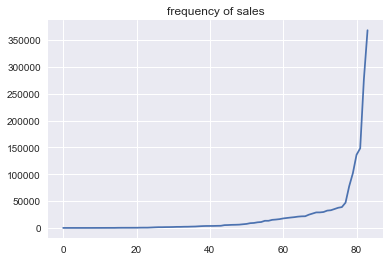

In [1063]:
item_categories['frequency of sales'].sort_values().reset_index(drop=True).plot(figsize=(6, 4), title='frequency of sales')

In [63]:
shops_clusters = pd.DataFrame(main_data.shop_id.unique(), columns=['shop_id'])
shops_clusters.index = shops_clusters['shop_id']

#### Clustering: shops per category / month sales profiles

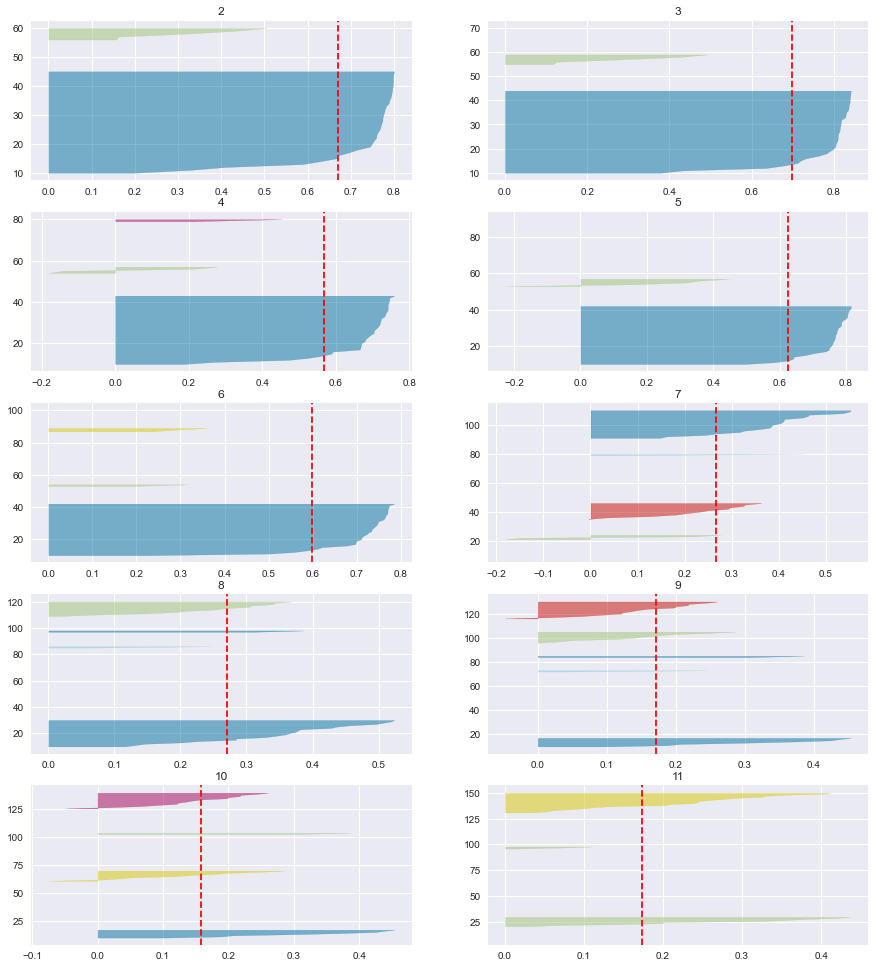

In [100]:
shops_in =set(main_data.query('date_block_num==33 & age_shop_days>390').shop_id.unique()
             ) - set()
categories_in = item_categories[item_categories['frequency of sales']>500].item_category_id.values
to_clustering = main_data.query('item_category_id in @categories_in & shop_id in @shops_in &(20 < date_block_num < 33)')

to_clustering = to_clustering.groupby(['item_category_id', 'shop_id'], as_index=False).sales.sum()

index, columns, values, aggfunc = 'shop_id', ['item_category_id'], 'sales', 'sum'
to_clustering, tmp_clusters = pca_pt_of_sales(index, columns, values, 3, to_clustering, aggfunc, pca_= False)
cla(to_clustering, m=10, batch_size=15)

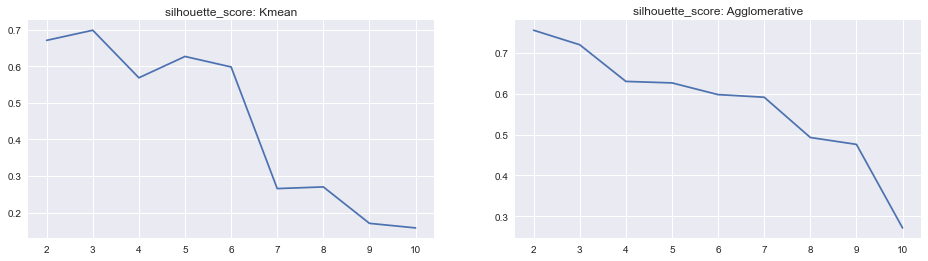

In [40]:
silhouette_scor(to_clustering)

In [193]:
lables = two_variants_clustering(6, to_clustering, method='aglom')
tmp_clusters['clusters'] = lables

silhouette_score KMeans, n=6: 0.5979678820212087
silhouette_score Aglom, n=6: 0.5979678820212087


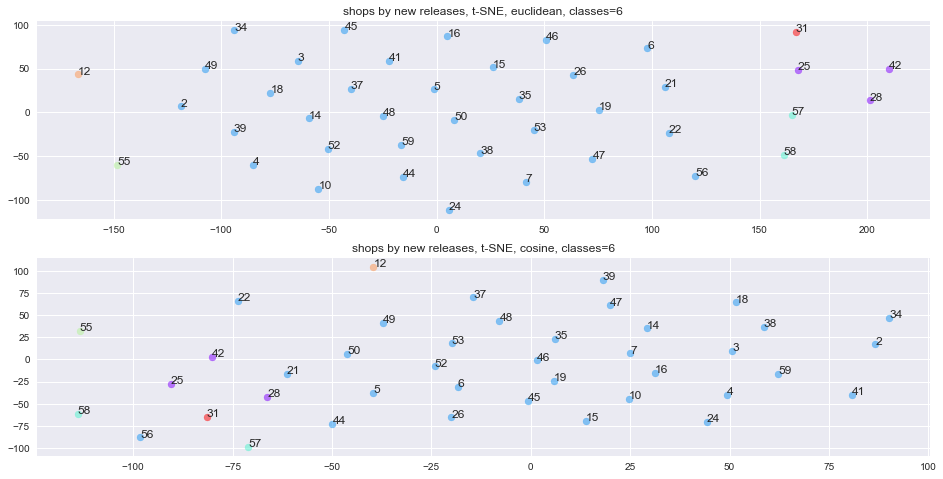

In [42]:
tsne_(to_clustering, tmp_clusters, perplexity=30)

In [194]:
shops_clusters['cluster_shop_categories'] = np.nan
shops_clusters.loc[tmp_clusters.shop_id.values, 'cluster_shop_categories'] = lables

#### Clustering: shops per category / month share of sales profiles

In [94]:
to_clustering = main_data.copy()
tmp = to_clustering.groupby(['shop_id'], as_index=False).sales.sum() #, 'date_block_num'

to_clustering = to_clustering.groupby(['item_category_id', 'shop_id'], as_index=False).sales.sum()
to_clustering = to_clustering.merge(tmp, how='left', on=['shop_id'])
to_clustering.sales_x = to_clustering.sales_x/to_clustering.sales_y

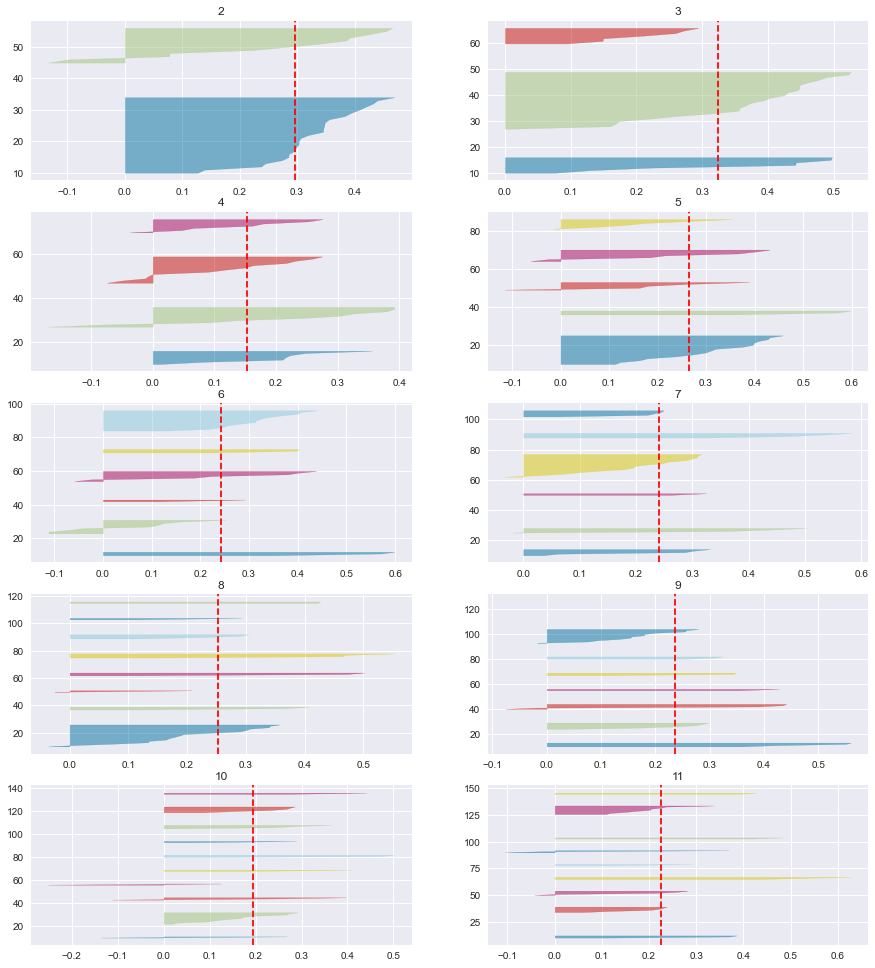

In [95]:
shops_in =set(main_data.query('date_block_num==33 & age_shop_days>390').shop_id.unique()) - {55, 12, 22, 39}
categories_in = item_categories[item_categories['frequency of sales']>1000].item_category_id.values
to_clustering = main_data.query('item_category_id in @categories_in & shop_id in @shops_in &(20 < date_block_num < 33)')

to_clustering = main_data.query('shop_id in @shops_in')


shops_in =set(main_data.query('date_block_num==33').shop_id.unique()) #- {12, 55}
tmp = to_clustering.groupby(['shop_id'], as_index=False).sales.sum() #, 'date_block_num'

to_clustering = to_clustering.groupby(['item_category_id', 'shop_id'], as_index=False).sales.sum()
to_clustering = to_clustering.merge(tmp, how='left', on=['shop_id'])
to_clustering.sales_x = to_clustering.sales_x/to_clustering.sales_y

index, columns, values, aggfunc = 'shop_id', ['item_category_id'], 'sales_x', 'mean'
to_clustering, tmp_clusters = pca_pt_of_sales(index, columns, values, 10, to_clustering, aggfunc, pca_= False)
cla(to_clustering, m=10, batch_size=15)

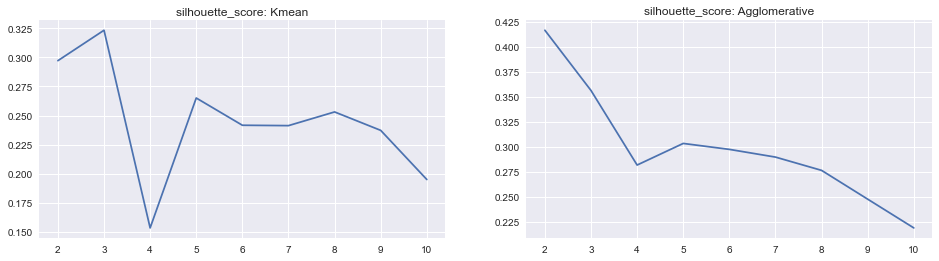

In [96]:
silhouette_scor(to_clustering)

In [98]:
lables = two_variants_clustering(2, category_sales=to_clustering, method='aglom')
tmp_clusters['clusters'] = lables

silhouette_score KMeans, n=2: 0.2971540500249951
silhouette_score Aglom, n=2: 0.41632341752485674


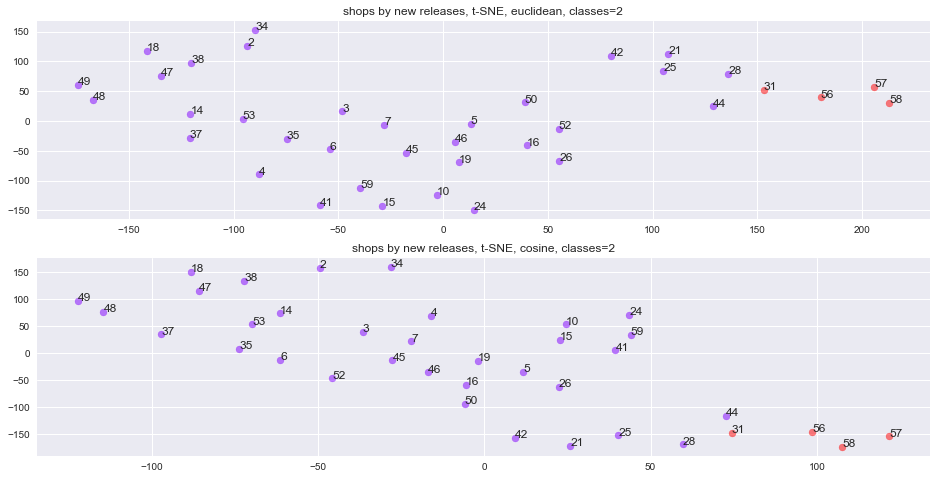

In [99]:
tsne_(to_clustering, tmp_clusters, perplexity=10)

In [197]:
shops_clusters['cluster_share'] = np.nan
shops_clusters.loc[tmp_clusters.shop_id.values, 'cluster_share'] = lables

In [352]:
shops_clusters = shops_clusters.reset_index(drop=True)
shops_clusters.to_csv('shops_clusters.csv')

<h2 id="aggregation"> Data aggregation</h2>

In [ ]:
# main_data - monthly agregated original data
# data_for_training - trainong drid

In [78]:
def lagger(data, data_for_training, index_keys, agg_column, lags=[], diff=[], MA=[], alpha=0.3, mode='test'):
    '''
    lagging and calculation of some agrefations (EMA, cumsumms, historical means, diff-s ) for data
    merging with training grid
    '''
    if 'cumsum' in MA: sales = Sales_pt(data, index_keys, count=True, column=agg_column)
    else: sales = Sales_pt(data, index_keys, count=False, column=agg_column)
    sales_lags = []
    lags_ = [1, 2, 3, 4, 5, 6]
    res = sales.sum.fillna(0).stack().reset_index().drop(0, axis=1)
    for k in lags_:
        sales_lags.append(sales.sum.shift(k, axis = 1))
        if k in lags:
            b = sales_lags[k-1].stack().reset_index()
            b = b.rename(columns={0: agg_column+'_lag_'+str(k)})
            res = res.merge( b, how='left', on=index_keys+['date_block_num'])
    diffs = []
    for k in diff:
        diffs.append(sales_lags[k-1] - sales_lags[k])
        b = diffs[k-1].stack().reset_index()
        b = b.rename(columns={0: agg_column+'_diff_'+str(k)})
        res = res.merge( b, how='left', on=index_keys+['date_block_num'])
    if 'EMA6' in MA:
        aa = np.array([(1 - alpha)**k for k in range(0, 6)])
        EMA = sum([aa[k]*sales_lags[k].fillna(0) for k in range(0, 6)])/aa.sum()
        b = EMA.stack().reset_index()
        b = b.rename(columns={0: agg_column+'_EMA6'})
        res = res.merge( b, how='left', on=index_keys+['date_block_num'])
    if 'EMA3' in MA:    
        aa = np.array([(1 - alpha)**k for k in range(0, 3)])
        EMA = sum([aa[k]*sales_lags[k].fillna(0) for k in range(0, 3)])/aa.sum()
        b = EMA.stack().reset_index()
        b = b.rename(columns={0: agg_column+'_EMA3'})
        res = res.merge( b, how='left', on=index_keys+['date_block_num'])
    if 'cumsum' in MA:
        tmp_cumsum = sales_lags[0].fillna(0).cumsum(axis=1)
        tmp_cumcount = sales.sales.fillna(0).shift(1, axis = 1).cumsum(axis=1)
        b = tmp_cumsum.stack().reset_index()
        b = b.rename(columns={0: agg_column+'_cumsum'})
        res = res.merge( b, how='left', on=index_keys+['date_block_num'])
        b = (tmp_cumsum/tmp_cumcount).stack().reset_index()
        b = b.rename(columns={0: agg_column+'_cumsum_mean'})
        res = res.merge( b, how='left', on=index_keys+['date_block_num'])
    if mode=='test': return res
    return data_for_training.merge(res, how='left', on=['date_block_num']+index_keys)   

def post_fillna(df):
    columns = []
    for c in df.columns: 
        if 'EMA' in c or 'cumsum' in c or 'other_sales' in c: columns.append(c)
    df.loc[:, columns] = df.loc[:, columns].fillna(0).values
    return df        

def add_parameter(df_, source, parameter, keys):
    index_head = ['shop_id', 'item_id', 'date_block_num']
    df = df_.loc[:, index_head].merge(source.loc[:, keys + [parameter]], how='left', on=keys)
    return df

In [11]:
grid = get_grid(main_data)

### Basic features: sales, shops, item categories, places

In [257]:
data_for_training = copy.deepcopy(grid)
data_for_training = data_for_training.merge(items.loc[:, ['item_id', 'item_category_id']], how = 'left', on=['item_id'])

#### Target

In [258]:
index_head = ['shop_id', 'item_id', 'date_block_num']
target = data_for_training.merge(main_data.loc[:, index_head + ['sales']], how='left', on=index_head)
f = lambda x: np.clip(x, 0, 20)
target.sales = f(target.sales.values)

filename = 'target_new.csv'
target[(target['date_block_num']>1)&
       (target['date_block_num']<34)].reset_index(drop=True).fillna(0).to_csv(filename)

In [1203]:
for i in range(27, 34):
    tmp = target.query('date_block_num==@i').loc[:, 'sales']
    print('{}: {:.4f}, {:.4f}, {:.4f}'.format(i, tmp.sum()/tmp.shape[0], tmp[tmp>0].shape[0]/tmp.shape[0], tmp[tmp>10].shape[0]/tmp.shape[0]))

27: 0.2544, 0.1334, 0.0026
28: 0.2600, 0.1385, 0.0021
29: 0.2650, 0.1423, 0.0021
30: 0.2600, 0.1466, 0.0017
31: 0.2886, 0.1561, 0.0019
32: 0.2707, 0.1389, 0.0028
33: 0.2583, 0.1387, 0.0023


#### Sales

In [259]:
%%time
#sales
index_keys = ['shop_id', 'item_id']
data_for_training =lagger(main_data, data_for_training, index_keys, 'sales', 
                          lags=[1, 2, 3], diff=[1, 2], MA=['EMA3', 'EMA6','cumsum'], alpha=0.3, mode=None)
data_for_training = lagger(main_data, data_for_training, index_keys, 'sales',
                           MA=['EMA3', 'EMA6'], alpha=0.2, mode=None)
#revenue
data_for_training =lagger(main_data, data_for_training, index_keys, 'revenue',
                          MA=['EMA3', 'EMA6'], alpha=0.3, mode=None)

CPU times: user 3min 10s, sys: 1min 20s, total: 4min 30s
Wall time: 4min 16s


#### Shops 

In [260]:
filename = 'shops_plus.csv'
shops = pd.read_csv(filename, index_col=0)
data_for_training = data_for_training.merge(shops.loc[:, ['shop_id', 'places', 'kind_of_shops']], how='left', on='shop_id')

In [261]:
# shop sales
tmp = main_data.groupby(['shop_id', 'date_block_num'], as_index=False).sales.sum()
tmp = tmp.rename(columns={'sales': 'shop_sales'})
index_keys = ['shop_id']
data_for_training = lagger(tmp, data_for_training, index_keys, 'shop_sales',
                           lags=[1], diff=[1], MA=['EMA3'], alpha=0.3, mode=None)

# number of items per shop
tmp = main_data.groupby(['shop_id', 'date_block_num'], as_index=False).item_id.count()
tmp = tmp.rename(columns={'item_id': 'shop_#items'})
index_keys = ['shop_id']
data_for_training = lagger(tmp, data_for_training, index_keys, 'shop_#items',
                           lags=[], diff=[1], MA=['EMA3'], alpha=0.3, mode=None)

# number of items per shop/category
tmp = main_data.groupby(['shop_id', 'item_category_id', 'date_block_num'], as_index=False).item_id.count()
tmp = tmp.rename(columns={'item_id': 'shop_category_#items'})
index_keys = ['shop_id', 'item_category_id']
data_for_training = lagger(tmp, data_for_training, index_keys, 'shop_category_#items',
                           lags=[], diff=[], MA=['EMA3'], alpha=0.3, mode=None)

#### Item category

In [262]:
# sales per item_category / shop
tmp = main_data.groupby(['item_category_id', 'shop_id','date_block_num'], as_index=False).sales.sum()
tmp = tmp.rename(columns={'sales': 'item_category_shop_sales'})
index_keys = ['shop_id', 'item_category_id']
data_for_training = lagger(tmp, data_for_training, index_keys, 'item_category_shop_sales',
                           lags=[1], diff=[1], MA=['EMA3', 'EMA6', 'cumsum'], alpha=0.3, mode=None)

#structure
index_keys = ['shop_id', 'item_category_id']
columns = [index_keys + ['category_shop_sales_structure']]
tmp = main_data.groupby(['item_category_id', 
                         'shop_id','date_block_num'], as_index=False)['category_shop_sales_structure'].mean()
data_for_training = lagger(tmp, data_for_training, index_keys, 'category_shop_sales_structure', 
                           lags=[], diff=[1], MA=['EMA3'], alpha=0.3, mode=None)

#### other sales in the same place Places

In [263]:
data = copy.deepcopy(grid)
columns = ['sales', 'revenue']
data = data.merge(main_data.loc[:, index_head+columns], how='left', on=index_head)
data = data.merge(items.loc[:, ['item_id', 'item_category_id']], how = 'left', on=['item_id'])
data['places'] = data.shop_id.replace(places)

In [264]:
#  weights (auxiliary)

tmp = data.groupby(['date_block_num', 'places', 'item_category_id'], as_index=False).sales.sum()
tmp.rename(columns={'sales': 'place category sales'}, inplace=True)
data = data.merge(tmp, how = 'left', on=['date_block_num', 'places', 'item_category_id'])

for columns in [(['date_block_num', 'shop_id', 'item_category_id'], 'category_shop_')]:
    for b in ['sum']:
        tmp = agregator(columns[0], 'sales', columns[1]+'sales_'+b, agg=b)
        data = data.merge(tmp, how = 'left', on=columns[0])     

In [266]:
# othes sales (sales of othe shops in the same city) 
places_ = data.loc[:, ['date_block_num', 'item_id', 'sales', 'places']].groupby(
                          ['date_block_num', 'item_id', 'places'], as_index=False).sum()
places_.drop(places_[places_.loc[:, 'places']==0].index, inplace=True)
places_.rename(columns={'sales': 'other sales'}, inplace=True)

data = data.merge(places_, how = 'left', left_on=['date_block_num', 'item_id', 'places'], 
                                                  right_on=['date_block_num', 'item_id', 'places'])
data.loc[:, 'sales'] = data.loc[:, 'sales'].fillna(0)

data.loc[:, 'other_sales_adj_mean'] = data.apply(lambda x: 
                  x['category_shop_sales_sum']*(x['other sales']-x['sales'])/(x['place category sales']-x['category_shop_sales_sum'])
                  if (x['place category sales']-x['category_shop_sales_sum']) > 0 else np.nan, axis=1)
data.drop(['other sales', 'place category sales', 'category_shop_sales_sum'], axis=1, inplace=True)

data.loc[:, 'other_sales_diff_a.'] = data.apply(lambda x: x['other_sales_adj_mean'] - x['sales'], axis=1)

In [267]:
data.to_csv('other_sales.csv')

In [20]:
data = pd.read_csv('other_sales.csv', index_col=0)

In [268]:
tmp = data.loc[:, index_head + ['other_sales_adj_mean']]
index_keys = ['shop_id', 'item_id']
data_for_training =lagger(data, data_for_training, index_keys, 'other_sales_adj_mean', 
                          lags=[1], diff=[1], MA=['EMA3'], alpha=0.3, mode=None)
tmp = data.loc[:, index_head + ['other_sales_diff_a.']]
data_for_training =lagger(data, data_for_training, index_keys, 'other_sales_diff_a.', 
                          lags=[1], diff=[], MA=['EMA3'], alpha=0.3, mode=None)

In [269]:
places = shops.loc[:, ['shop_id', 'places']].set_index('shop_id').to_dict()['places']
data_for_training['places'] = data_for_training['shop_id'].replace(places)

In [270]:
n_shops_place = pd.read_csv('n_shops_place.csv', index_col=0)
data_for_training = data_for_training.merge(n_shops_place, how='left', on=['places', 'date_block_num'])

le_places = preprocessing.LabelEncoder()

tmp = data_for_training.loc[:, 'places'].replace({0: 'zzz'}).fillna('zzz')
data_for_training.loc[:, 'places'] = le_places.fit_transform(tmp)

In [271]:
prices = pd.read_csv('sale_prices.csv', index_col=0)
data_for_training = data_for_training.merge(prices, how='left', on=['shop_id', 'item_id', 'date_block_num'])

/Users/olip.andrei/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [275]:
data_for_training = post_fillna(data_for_training)
data_for_training = reduce_mem_usage(data_for_training)

In [276]:
filename = 'data_for_training_base_features_unclipped.csv'
data_for_training[data_for_training['date_block_num']>1].reset_index(drop=True).to_csv(filename)

In [277]:
#clipping and -->> saving
data_for_training = post_fillna(data_for_training)
data_for_training = reduce_mem_usage(data_for_training)

to_clip = ['sales_lag_1', 'sales_lag_2', 'sales_lag_3', 'sales_EMA3_x', 'sales_EMA3_y', 
           'sales_EMA6_x', 'sales_EMA6_y', 'sales_cumsum_mean'] + [
           'other_sales_adj_mean_lag_1', 'other_sales_adj_mean_EMA3']

f = lambda x: np.clip(x, 0, 20)
data_for_training.loc[:, to_clip] = f(data_for_training.loc[:, to_clip].values)

filename = 'data_for_training_base_features.csv'
data_for_training[data_for_training['date_block_num']>1].reset_index(drop=True).to_csv(filename)

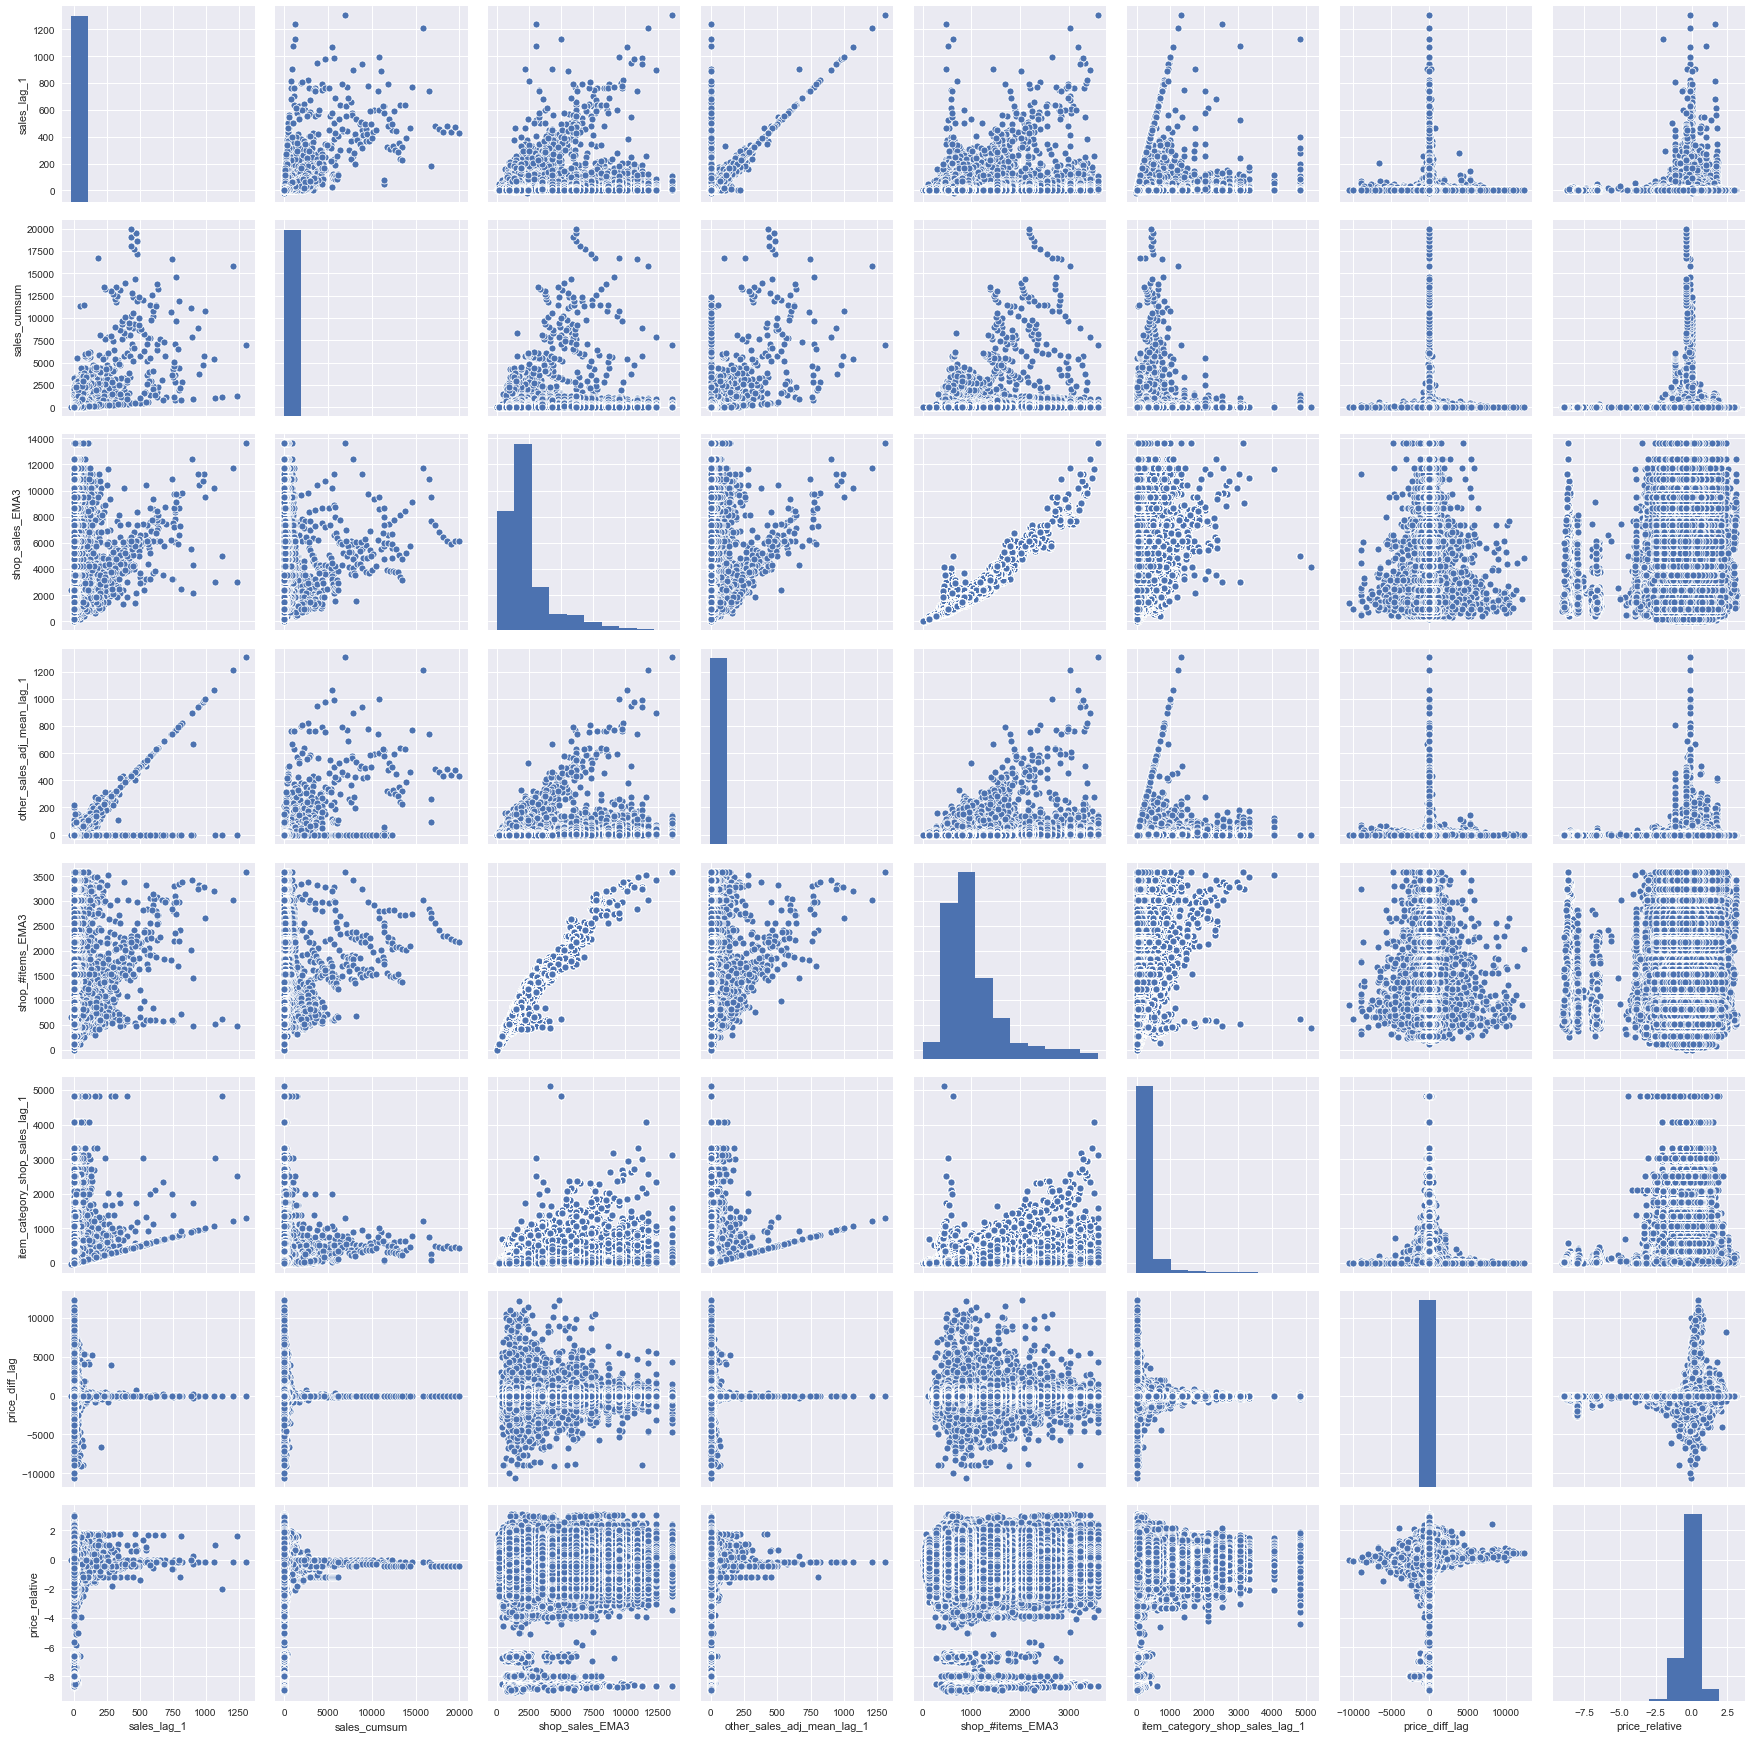

In [17]:
columns = ['sales_lag_1', 'sales_cumsum', 'shop_sales_EMA3', 'other_sales_adj_mean_lag_1',
           'shop_#items_EMA3', 'item_category_shop_sales_lag_1', 'price_diff_lag', 'price_relative']

sns.pairplot(data_for_training.loc[:, columns].replace([-999, np.inf, -np.inf], np.nan), dropna=True, height=3)

### Further agregation: items, item names

#### Items: not shop agregations

Agregation types:
- all: sum (lag 1, diff 1), mean (lag 1, EMA, etc.)
- all weighted: mean (lag 1, EMA, etc.)
- neighbor: mean (lag 1, EMA, etc.) + weighted
- clusters: mean (lag 1, EMA, etc.) + weighted

plus:
- new items:  current and as  shop characteristic
- cluster ids

In [188]:
data_for_training = copy.deepcopy(grid)
data_for_training = data_for_training.merge(items.loc[:, ['item_id', 'item_category_id']], how = 'left', on=['item_id'])

In [279]:
#  all:

In [189]:
tmp = main_data.groupby(['date_block_num','item_id'], as_index=False).sales.sum()
tmp.rename(columns={'sales': 'items_all_sum'}, inplace=True)
index_keys = ['item_id']
data_for_training =lagger(tmp, data_for_training, index_keys, 'items_all_sum', 
                          lags=[1], diff=[1], MA=['EMA3', 'EMA6','cumsum'], alpha=0.3, mode=None)

In [191]:
class Weighting:
    def __init__(self):
        all_sales = (main_data.groupby(['date_block_num', 'shop_id'], 
                                 as_index=False).sales.sum()).groupby('date_block_num', as_index=False).sales.mean()

        weights = main_data.groupby(['shop_id', 'date_block_num'], as_index=False).sales.sum()
        weights = weights.rename(columns={'sales': 'shop_weights'})
        weights = weights.merge(all_sales, how='left', on='date_block_num')
        weights['shop_weights'] = weights['shop_weights']/weights['sales']
        self.weights = weights.drop('sales', axis=1)
    def transform(self, df_, to_transform):
        df = df_.copy()
        df = df.merge(self.weights, how='left', on=['date_block_num', 'shop_id'])
        for c in to_transform:
            df[c+'_weighted'] =  df[c] * df['shop_weights'] 
        df.drop(['shop_weights']+to_transform, axis=1, inplace=True)
        return df
weighting = Weighting()       

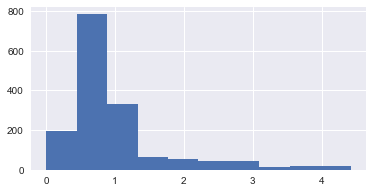

In [82]:
weighting.weights.shop_weights.hist(figsize=(6, 3))

In [192]:
tmp = main_data.groupby(['date_block_num','item_id'], as_index=False).sales.mean()
tmp.rename(columns={'sales': 'items_all_mean'}, inplace=True)
index_keys = ['item_id']
data_for_training = lagger(tmp, data_for_training, index_keys, 'items_all_mean', 
                          lags=[1], diff=[], MA=['EMA3','cumsum'], alpha=0.3, mode=None)

tmp = add_parameter(data_for_training, tmp, 'items_all_mean', ['item_id', 'date_block_num'])
tmp = weighting.transform(tmp, ['items_all_mean'])
index_keys = ['shop_id', 'item_id']
data_for_training = lagger(tmp, data_for_training, index_keys, tmp.columns[-1], 
                           lags=[1], diff=[], MA=['EMA3'], alpha=0.3, mode=None)

In [283]:
# clusters

In [193]:
shops_clusters = pd.read_csv('shops_clusters.csv', index_col=0)
columns = ['shop_id', 'cluster_shop_categories', 'cluster_share']
main_data = main_data.merge(shops_clusters.loc[:, columns], how='left', on='shop_id')
data_for_training = data_for_training.merge(shops_clusters.loc[:, columns], how='left', on='shop_id')

In [194]:
for c in ['cluster_shop_categories', 'cluster_share']:
    tmp = main_data.groupby(['date_block_num', 'item_id', c], as_index=False).sales.mean()
    
    name = 'items_'+str(c)+'_mean'
    tmp.rename(columns={'sales': name}, inplace=True)
    index_keys = ['item_id', c]
    data_for_training = lagger(tmp, data_for_training, index_keys, name, 
                              lags=[1], diff=[1], MA=['EMA3', 'EMA6','cumsum'], alpha=0.3, mode=None)

In [195]:
for c in ['cluster_shop_categories', 'cluster_share']:
    tmp = main_data.groupby(['date_block_num', 'item_id', c], as_index=False).sales.sum()
    
    name = 'items_'+str(c)+'_sum'
    tmp.rename(columns={'sales': name}, inplace=True)
    index_keys = ['item_id', c]
    data_for_training = lagger(tmp, data_for_training, index_keys, name, 
                              lags=[1], diff=[1], MA=['EMA3', 'EMA6','cumsum'], alpha=0.3, mode=None)

##### New items

In [200]:
new_items = main_data[main_data.months_on_the_market==1].groupby(['date_block_num', 'item_category_id',
                                                                 'shop_id'], as_index=False).months_on_the_market.sum()
new_items = new_items.rename(columns={'months_on_the_market': 'new_items'})
tmp = main_data[main_data.months_on_the_market==1].groupby(['date_block_num','item_id']).mean().loc[:, 
                                                           ['item_category_id', 'months_on_the_market']].reset_index()
new_items_all = tmp.groupby(['date_block_num', 'item_category_id'], as_index=False).months_on_the_market.sum()
new_items_all = new_items_all.rename(columns={'months_on_the_market': 'new_items_all'})

new_items = new_items.merge(new_items_all, how='left', on=['date_block_num', 'item_category_id'])
new_items['new_items_relative'] = new_items['new_items']/new_items['new_items_all']
new_items.drop(['new_items_all'], axis=1, inplace=True)

In [288]:
new_items.head()

,date_block_num,item_category_id,shop_id,new_items,new_items_relative
0,0,0,25,1.0,1.000000
1,0,1,45,1.0,1.000000
2,0,2,2,10.0,0.270270
3,0,2,3,9.0,0.243243
4,0,2,4,11.0,0.297297


In [201]:
index_keys = ['item_category_id', 'shop_id']
for name in ['new_items', 'new_items_relative']:
    data_for_training = lagger(new_items, data_for_training, index_keys, name, 
                               lags=[1], diff=[], MA=['EMA3'], alpha=0.3, mode=None)

In [202]:
general = pd.read_csv('general.csv', index_col=0)
columns = ['item_id', 'neighbors_id_01', 'neighbors_id_25', 'neighbors_id_4', 'platform_item'] 
main_data = main_data.merge(general.loc[:, columns], how='left', on='item_id')

In [203]:
columns = ['item_id', 'neighbors_id_01', 'neighbors_id_25', 'neighbors_id_4', 'platform_item']
data_for_training = data_for_training.merge(general.loc[:, columns], how='left', on='item_id')

music = pd.read_csv('music.csv', index_col=0)
columns = ['item_id', 'musicians'] 
main_data = main_data.merge(music.loc[:, columns], how='left', on='item_id')
data_for_training = data_for_training.merge(music.loc[:, columns], how='left', on='item_id')

In [204]:
for c in ['neighbors_id_01', 'neighbors_id_25', 'neighbors_id_4', 'platform_item', 'musicians']:
    tmp = main_data[main_data.months_on_the_market==1].groupby(['date_block_num', c, 'item_id'], as_index=False).sales.mean()
    tmp = tmp.groupby(['date_block_num', c], as_index=False).item_id.count()
    name = c+'_new'
    tmp.rename(columns={'item_id': name}, inplace=True)
    index_keys = [c]
    data_for_training = lagger(tmp, data_for_training, index_keys, name, 
                               lags=[1, 2, 3], diff=[], MA=['EMA3', 'EMA6', 'cumsum'], alpha=0.3, mode=None)

In [206]:
# current
def get_n_of_current_new_items(columns):
    global data_for_training
    for c in columns:
        tmp = main_data[main_data.months_on_the_market==1].groupby(['date_block_num', c, 'item_id'], as_index=False).sales.mean()
        tmp = tmp.groupby(['date_block_num', c], as_index=False).item_id.count()
        tmp = tmp.rename(columns={'item_id': 'new_items_'+c})
        data_for_training = data_for_training.merge(tmp, on=[c, 'date_block_num'], how='left')
columns = ['item_category_id', 'neighbors_id_01', 'neighbors_id_25', 'neighbors_id_4', 'platform_item', 'musicians'] 
get_n_of_current_new_items(columns)

In [207]:
data_for_training = reduce_mem_usage(data_for_training)

In [208]:
# saving
data_for_training = reduce_mem_usage(data_for_training)
filename = 'data_for_training_items.csv'
data_for_training[data_for_training['date_block_num']>1].reset_index(drop=True).to_csv(filename)

#### Features agregation: category groups

In [296]:
data_for_training = copy.deepcopy(grid)

In [297]:
data_for_training = data_for_training.merge(items.loc[:, ['item_id', 'item_category_id']], how = 'left', on=['item_id'])

columns = ['category_groups', 'platforms', 'types']
data_for_training = data_for_training.merge(item_categories.loc[:, ['item_category_id']+columns], how = 'left', on=['item_category_id'])

In [298]:
# sales per category_groups / shop
tmp = main_data.groupby(['category_groups', 'shop_id','date_block_num'], as_index=False).sales.sum()
name= 'category_groups_shop'
tmp = tmp.rename(columns={'sales': name})
index_keys = ['shop_id', 'category_groups']
data_for_training = lagger(tmp, data_for_training, index_keys, name,
                           lags=[], diff=[], MA=['EMA3', 'cumsum'], alpha=0.3, mode=None)

# sales per category_groups / all
tmp = main_data.groupby(['category_groups', 'date_block_num'], as_index=False).sales.sum()
name= 'category_groups_all'
tmp = tmp.rename(columns={'sales': name})
index_keys = ['category_groups']
data_for_training = lagger(tmp, data_for_training, index_keys, name,
                           lags=[], diff=[], MA=['EMA3'], alpha=0.3, mode=None)

In [299]:
# sales per platforms / shop
tmp = main_data.groupby(['platforms', 'shop_id','date_block_num'], as_index=False).sales.sum()
name= 'platforms_shop'
tmp = tmp.rename(columns={'sales': name})
index_keys = ['shop_id', 'platforms']
data_for_training = lagger(tmp, data_for_training, index_keys, name,
                           lags=[1], diff=[], MA=['EMA3'], alpha=0.3, mode=None)

In [300]:
# sales per types / shop
tmp = main_data.groupby(['types', 'shop_id','date_block_num'], as_index=False).sales.sum()
name= 'types_shop'
tmp = tmp.rename(columns={'sales': name})
index_keys = ['shop_id', 'types']
data_for_training = lagger(tmp, data_for_training, index_keys, name,
                           lags=[1], diff=[], MA=['EMA3', 'cumsum'], alpha=0.3, mode=None)

In [301]:
le = preprocessing.LabelEncoder()

for c in ['category_groups', 'platforms', 'types']:
    tmp = data_for_training.loc[:, c].replace({0: 'zzz'}).fillna('zzz')
    data_for_training.loc[:, c] = le.fit_transform(tmp)

In [302]:
data_for_training.drop(['item_category_id'], axis=1, inplace=True)

In [303]:
data_for_training = reduce_mem_usage(data_for_training)
filename = 'category_groups_features.csv'
data_for_training[data_for_training['date_block_num']>1].reset_index(drop=True).to_csv(filename)

#### Features agregation: item names

In [240]:
def encoder(data, column_names, column_to_agrigate='sales', alpha=0.3):
    data_ = data.copy()
    for columns_name in column_names:
        for second in [['shop_id']]: 
            index_keys = second + [columns_name]
            tmp = data.groupby(index_keys + ['date_block_num'], as_index=False)[column_to_agrigate].sum()
            name= columns_name+'_'+column_to_agrigate
            tmp = tmp.rename(columns={column_to_agrigate: name})
            data_ = lagger(tmp, data_, index_keys, name,
                                       lags=[1], diff=[], MA=['EMA3', 'EMA3', 'cumsum'], alpha=0.3, mode=None)
    return data_.replace([np.inf, -np.inf], np.nan) 

In [241]:
data_for_training = copy.deepcopy(grid)

In [242]:
files = [
'general.csv',
'brackets.csv',
'music.csv',
'movies.csv',   
'games.csv',
'rest15.csv']

In [243]:
for f in files:
    source = pd.read_csv(f, index_col=0)
    data_for_training = data_for_training.merge(source, how='left', on='item_id')

In [244]:
data_for_training['item_year'] = data_for_training['date_block_num'].map(lambda x: 2013 + x//12) - data_for_training['item_year']

In [245]:
index_head = ['shop_id', 'item_id', 'date_block_num']
data_for_training = data_for_training.merge(main_data.loc[:, index_head + ['sales', 'revenue']], how='left', on=index_head)
f = lambda x: np.clip(x, 0, 20)
data_for_training['sales_clipped'] = f(data_for_training['sales'].values)

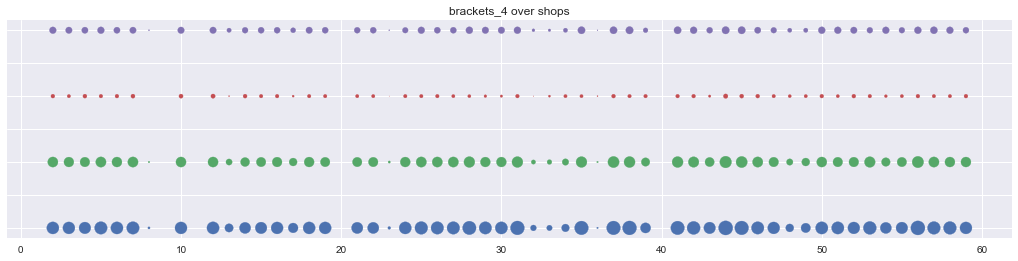

In [73]:
# distribution of cat features over shops
c = 'brackets_4'
data = pd.concat([data_for_training.loc[:, ['shop_id', 'date_block_num', c]], 
                  target], axis=1).query('sales>0 and date_block_num < 34').dropna().astype(int).groupby(['shop_id', c], as_index=False)['sales'].count().pivot_table(index=c, 
                     columns='shop_id', values='sales', aggfunc='sum')

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(18, 4))
axes.set_title(c+ ' over shops')
axes.set(yticklabels=[])

gamma = 200/data.max().max()
for i in range(data.shape[0]):
    tmp = data.columns
    shops = (i+0.5)*data.iloc[i, :].map(np.sign)
    axes.scatter(tmp, shops, s=gamma*data.iloc[i, :], label='shop_id')

In [224]:
#coverage
ss = data_for_training.sales.sum()
cc = data_for_training.sales.count()
for c in ['neighbors_id_01', 'neighbors_id_15', 'neighbors_id_25', 'neighbors_id_31', 'neighbors_id_4']:
    print('{}: sales - {:.2f}, #sales - {:.2f}'.format(c, data_for_training.groupby(c).sales.sum().sum()/ss,
                                         data_for_training.groupby(c).sales.count().sum()/cc))

neighbors_id_01: sales - 0.50, #sales - 0.47
neighbors_id_15: sales - 0.53, #sales - 0.50
neighbors_id_25: sales - 0.58, #sales - 0.54
neighbors_id_31: sales - 0.62, #sales - 0.58
neighbors_id_4: sales - 0.68, #sales - 0.65


In [246]:
#item name
from nltk.corpus import stopwords
all_stopwords = stopwords.words("russian") + stopwords.words("english")
all_stopwords = []
work = items.copy()
npp = NamePreProcessing([], r'[^A-ZА-Яa-zа-я0-9\s]')
def f(string, stopwords):
    tokens = string.split(' ') 
    tokens = [t for t in tokens if t not in stopwords]
    return ' '.join(tokens)
work['item_name'] = work.item_name.map(lambda x: f(npp.prepr(x), all_stopwords))

In [247]:
columns = ['platform_item', '1c', 'important_words']
data_for_training = encoder(data_for_training, columns, column_to_agrigate='revenue')
data_for_training = data_for_training.merge(work.loc[:, ['item_name', 'item_id']], how='left', on='item_id')

In [182]:
# knn statistics: # objects in ctluster, distanciesdistancies
items_in = {}
for m in range(2, 35):
    items_in.update({m: data_for_training.query('date_block_num<=@m').item_id.unique()})

neighbors_knn_params = {}
for n in ['01', '25', '4']:
    neighbors_knn_params.update({n: pd.DataFrame([])})
    neighbors_id = 'neighbors_id_'+n
    columns_output=['date_block_num', neighbors_id, 'len'+n, 'dist_max_'+n, 'dist_mean_'+n]
    for m in range(2, 35):
        columns = ['date_block_num', 'neighbors_'+n, 'distancies_'+n]
        neighbors_id_in = data_for_training.query('date_block_num==@m'
                                                 ).groupby(neighbors_id, as_index=False)[columns].first()
        neighbors_id_in.loc[:, 'neighbors_'+n] = neighbors_id_in.loc[:, 'neighbors_'+n].map(lambda x: [int(b) for b in x[1:-1].split(' ') if len(b)>0])
        neighbors_id_in.loc[:, 'distancies_'+n] = neighbors_id_in.loc[:, 'distancies_'+n].map(lambda x: [float(b) for b in x[1:-1].split(' ') if len(b)>0])
        neighbors_id_in['mask']=neighbors_id_in.loc[:, 'neighbors_'+n].map(lambda x: np.where(np.isin(x,  items_in[m]), True, False))
        neighbors_id_in['len_'+n]=neighbors_id_in['mask'].map(sum)
        neighbors_id_in['dist_max_'+n] = (neighbors_id_in.loc[:, 'distancies_'+n]*neighbors_id_in.loc[:, 'mask']).map(max)
        neighbors_id_in['dist_mean_'+n] = (neighbors_id_in.loc[:, 'distancies_'+n]*neighbors_id_in.loc[:, 'mask']).map(np.mean)
        neighbors_knn_params[n] = pd.concat([neighbors_knn_params[n], neighbors_id_in])

In [251]:
neighbors_knn_params['4'].head()

,neighbors_id_4,date_block_num,neighbors_4,distancies_4,mask,len_4,dist_max_4,dist_mean_4
0,3.0,2,"[12, 14690, 14691]","[0.0, 0.0, 0.11978606]","[True, True, False]",2,0.0,0.0
1,5.0,2,"[27, 29, 28]","[0.0, 0.0, 0.0]","[True, True, True]",3,0.0,0.0
2,6.0,2,"[31, 30]","[0.0, 0.0]","[True, True]",2,0.0,0.0
3,7.0,2,"[35, 36, 37]","[0.0, 0.0, 0.0]","[True, True, True]",3,0.0,0.0
4,8.0,2,"[67, 66, 64, 63]","[0.0, 0.0, 0.0, 0.0]","[False, False, False, True]",1,0.0,0.0


In [ ]:
columns = ['neighbors_id_25', 'date_block_num', 'len_25', 'dist_max_25', 'dist_mean_25']
data_for_training = data_for_training.merge(neighbors_knn_params['25'].loc[:, columns], how='left', on=['neighbors_id_25', 'date_block_num'])
columns = ['neighbors_id_01', 'date_block_num', 'len_01']
data_for_training = data_for_training.merge(neighbors_knn_params['01'].loc[:, columns], how='left', on=['neighbors_id_01', 'date_block_num'])
columns = ['neighbors_id_4', 'date_block_num', 'len_4', 'dist_max_4', 'dist_mean_4']
data_for_training = data_for_training.merge(neighbors_knn_params['4'].loc[:, columns], how='left', on=['neighbors_id_4', 'date_block_num'])

In [254]:
columns = ['musicians', 'neighbors_id_01', 'neighbors_id_25', 'neighbors_id_4', 'rest_15']
tmp = encoder(data_for_training, columns)

tmp = reduce_mem_usage(tmp)
filename = 'item_name_features.csv'
tmp[tmp['date_block_num']>1].reset_index(drop=True).to_csv(filename)

In [255]:
tmp = encoder(data_for_training, columns, column_to_agrigate='sales_clipped')
tmp.drop(['sales_clipped', 'sales'], axis=1, inplace=True)
tmp = tmp.merge(work.loc[:, ['item_name', 'item_id']], how='left', on='item_id')

tmp = reduce_mem_usage(tmp)
filename = 'item_name_features_clipped.csv'
tmp[tmp['date_block_num']>5].reset_index(drop=True).to_csv(filename)

In [18]:
data_for_training = reduce_mem_usage(pd.read_csv('item_name_features.csv', 
                                                 index_col=0)).query('date_block_num>2').reset_index(drop=True)

In [256]:
del tmp

<h2 id="other"> Other features and statistics</h2>

In [321]:
grid = get_grid(main_data)

In [322]:
items = pd.read_csv(path.join(DATA_FOLDER, 'items.csv'))

In [323]:
data_for_training = copy.deepcopy(grid)
index_head = ['shop_id', 'item_id', 'date_block_num']
data_for_training = data_for_training.merge(items.loc[:, ['item_id', 'item_category_id'
                                                         ]], how='left', on='item_id')
data_for_training = data_for_training.merge(item_categories.loc[:, ['category_groups','item_category_id'
                                                         ]], how='left', on='item_category_id')
data_for_training = data_for_training.merge(main_data.loc[:, index_head + ['sales']], how='left', on=index_head)

In [324]:
general = pd.read_csv('general.csv', index_col=0)
columns = ['item_id', 'neighbors_35']
data_for_training = data_for_training.merge(general.loc[:, columns], how='left', on='item_id')

In [325]:
sales = Sales_pt(main_data, index_keys=['shop_id', 'item_id'], count=True)

#### Sales frequency per item / month

In [326]:
for c in ['item_id', 'neighbors_35']:
    columns = ['date_block_num', 'shop_id', c]
    sales_frequ = main_data.loc[:, columns].pivot_table(index=[c], columns='date_block_num', aggfunc='count')  
    shops_n = (main_data.groupby(['date_block_num', 'shop_id'], 
                      as_index=False).agg({'sales': 'count'}).groupby('date_block_num').agg({'shop_id': 'count'})).values
    sales_frequ = sales_frequ.div(np.vstack([shops_n.T]*sales_frequ.shape[0]))
    frequency_lags_tmp = sales_frequ.stack().reset_index()
    name = 'frequ_'+c
    frequency_lags_tmp = frequency_lags_tmp.rename(columns = {'shop_id': name})
    index_keys = [c]
    data_for_training =lagger(frequency_lags_tmp, data_for_training, index_keys, name, 
                              lags=[1], diff=[1, 2], MA=['EMA3', 'EMA6'], alpha=0.3, mode=None)

In [327]:
#  clusters
shops_clusters = pd.read_csv('shops_clusters.csv', index_col=0)
columns = ['shop_id', 'cluster_shop_categories', 'cluster_share']
main_data = main_data.merge(shops_clusters.loc[:, columns], how='left', on='shop_id')
data_for_training = data_for_training.merge(shops_clusters.loc[:, columns], how='left', on='shop_id')

In [328]:
data_for_training = encoder(data_for_training, ['cluster_shop_categories', 'cluster_share'])

In [329]:
tmp = main_data.groupby(['date_block_num', 'item_id', 'cluster_shop_categories'], as_index=False).sales.sum()
tmp.rename(columns={'sales': 'items_cluster_sum'}, inplace=True)
index_keys = ['item_id','cluster_shop_categories']
data_for_training =lagger(tmp, data_for_training, index_keys, 'items_cluster_sum', 
                          lags=[1], diff=[1], MA=['EMA3', 'EMA6','cumsum'], alpha=0.3, mode=None)

In [331]:
# other pre-calculated features

filename = 'category_first_sales.csv'
category_sales = pd.read_csv('category_first_sales.csv', index_col=0)
head = ['item_category_id', 'shop_id', 'date_block_num']
data_for_training = data_for_training.merge(category_sales, how='left', on=head)

filename = 'prio_2.csv'
prio = pd.read_csv(filename, index_col=0)
head = ['item_category_id', 'shop_id', 'date_block_num']
data_for_training = data_for_training.merge(prio, how='left', on=head)

In [332]:
data_for_training = reduce_mem_usage(data_for_training)

filename = 'features_spetial.csv'
data_for_training[data_for_training['date_block_num']>1].reset_index(drop=True).to_csv(filename)

### Additional features

In [ ]:
data_for_training = pd.concat([data_for_training_base, 
                               time_features.iloc[:, 3:]], axis=1)

new_features = []
head = ['date_block_num', 'item_id', 'places']
columns = ['month_n_sales', 'month_mean', 'month_last_sale_lag', 'days_in_shop']
tmp = data_for_training.groupby(head, as_index=False)[columns].mean()
for c in columns:
    tmp = tmp.rename(columns= {c: c+'_place'})
    new_features.append(c+'_place')
data_for_training = data_for_training.merge(tmp, how='left', on=head)
ii = data_for_training.query('months_on_the_market!=2').index
data_for_training.loc[ii, 'days_in_shop_place'] = np.nan
data_for_training['other_sales_mean_per_day'] = data_for_training['other_sales_adj_mean_lag_1']/data_for_training['days_in_shop_place']
data_for_training['other_sales_mean_adjusted'] = data_for_training['other_sales_mean_per_day']*data_for_training['n_of_days']
new_features += ['other_sales_mean_per_day', 'other_sales_mean_adjusted']

In [ ]:
head = ['date_block_num', 'item_id']
columns = ['month_n_sales', 'month_mean']
tmp = data_for_training.groupby(head, as_index=False)[columns].mean()
for c in columns:
    tmp = tmp.rename(columns= {c: c+'_all'})
    new_features.append(c+'_all')
data_for_training = data_for_training.merge(tmp, how='left', on=head) 

data_for_training['items_shop_lag_1_relarion_to_historical_mean'] = data_for_training['sales_lag_1']/data_for_training['sales_cumsum_mean']
add_features = data_for_training.copy()
add_features.to_csv('add_features.csv')

In [69]:
tmp = {'base': 'data_for_training_base_features_unclipped.csv',
       'time': 'data_for_training_time_features.csv',
       'items': 'data_for_training_items.csv',
       'category_groups': 'category_groups_features.csv',
       'item_name': 'item_name_features.csv',
       'spetial': 'features_spetial.csv',
       'add_features': 'add_features.csv'}         
with open('data_file_names.pkl', 'wb') as f:
    pickle.dump(tmp, f, pickle.HIGHEST_PROTOCOL)